In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.models import vgg11

from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt

from lib.models import model
from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

# Device

In [2]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

# Manual Seeding

In [3]:
seed_generators()

# Data

In [4]:
train_dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

# Server & Clients

In [6]:
num_clients = 8
num_classes = 10

## Data repartition among clients

In [7]:
proportions = generate_proportions(num_clients,num_classes)
proportions

[tensor([1.7277e-03, 1.4681e-03, 1.7119e-01, 6.7152e-08, 5.6816e-13, 3.8499e-02,
         1.0243e-05, 7.8711e-01]),
 tensor([1.0118e-01, 3.6152e-06, 1.2661e-02, 7.9172e-01, 5.1877e-21, 6.2118e-12,
         9.4433e-02, 3.0271e-15]),
 tensor([2.6149e-01, 2.5464e-01, 3.9212e-11, 8.3872e-11, 1.3594e-10, 3.5875e-01,
         1.1811e-01, 7.0036e-03]),
 tensor([9.6308e-04, 1.4171e-06, 6.7539e-05, 4.1170e-02, 8.3330e-04, 3.0664e-03,
         2.2048e-01, 7.3342e-01]),
 tensor([5.0231e-01, 2.2462e-11, 4.8773e-01, 1.6541e-03, 2.9940e-04, 9.7107e-06,
         6.0056e-03, 1.9903e-03]),
 tensor([6.4948e-06, 1.6067e-10, 9.1099e-09, 9.7064e-05, 1.0678e-03, 1.6058e-08,
         3.3956e-20, 9.9883e-01]),
 tensor([4.1385e-03, 8.2548e-01, 3.1079e-04, 2.0520e-11, 1.6359e-01, 5.3383e-07,
         3.7362e-05, 6.4420e-03]),
 tensor([8.4674e-01, 1.1771e-08, 8.1328e-03, 4.3720e-11, 7.8426e-02, 2.2480e-03,
         6.4372e-02, 7.9591e-05]),
 tensor([1.3971e-03, 7.3353e-18, 3.2855e-02, 1.9014e-01, 2.6827e-01, 5.9

# Cross Validation

In [8]:
def run_FedAvg(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights()
    for i in range(rounds):
        print(f'>>> Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        valid_loss, valid_acc = evaluate(server.net,valid_loader)
        
        print(f'''
Server :
    - training loss = {train_loss:.4f}
    - training accuracy = {train_acc:.4f}
    - validation loss = {valid_loss:.4f}
    - validation accuracy = {valid_acc:.4f}
        ''')
        
        history.append([train_loss, valid_loss, train_acc, valid_acc])
    return history

In [9]:
def run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,**kwargs):
    folds = KFold(n_splits=n_splits,shuffle=True,random_state=42).split(np.arange(len(train_dataset)))

    results = []
    for fold, (train_idx,valid_idx) in enumerate(folds):
        print("="*25)
        print(f"Fold #{fold}")
        print("="*25)

        # create train and validation subsets
        train_subset = Subset(train_dataset, train_idx)
        valid_subset = Subset(train_dataset, valid_idx)

        # split data between users
        partition = partition_by_class(train_subset)
        clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
        server = Server(model().to(device))
        
        for c in clients:
            print(f"client {c.client_id} : {len(c.dataset)} samples")
        print()
        
        history = run_FedAvg(server,clients,device,train_subset,valid_subset,rounds,epochs,batch_size,optimizer,lr,**kwargs)
        
        plot_loss_epoch(history)
        
        results.append(history[-1][-1])
        
        
    return torch.tensor(results).mean()

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.9771, Accuracy = 0.6602
client 2 : Loss = 0.1448, Accuracy = 0.9441
client 3 : Loss = 0.2537, Accuracy = 0.9030
client 4 : Loss = 0.4797, Accuracy = 0.8256
client 5 : Loss = 0.1411, Accuracy = 0.9492
client 6 : Loss = 0.1178, Accuracy = 0.9557
client 7 : Loss = 0.4629, Accuracy = 0.8283
client 8 : Loss = 0.5101, Accuracy = 0.7762

Server :
    - training loss = 2.3044
    - training accuracy = 0.2431
    - validation loss = 2.3544
    - validation accuracy = 0.2372
        
>>> Round 2 ...
client 1 : Loss = 0.9586, Accuracy = 0.6911
client 2 : Loss = 0.1129, Accuracy = 0.9569
client 3 : Loss = 0.1390, Accuracy = 0.9562
client 4 : Loss = 0.4244, Accuracy = 0.8588
client 5 : Loss = 0.0875, Accuracy = 0.9751
client 6 : Loss = 0.0859, Accuracy = 0.9707
cli

client 6 : Loss = 0.0181, Accuracy = 0.9967
client 7 : Loss = 0.0309, Accuracy = 0.9927
client 8 : Loss = 0.0207, Accuracy = 0.9944

Server :
    - training loss = 0.8567
    - training accuracy = 0.6929
    - validation loss = 1.3955
    - validation accuracy = 0.5568
        
>>> Round 17 ...
client 1 : Loss = 0.2635, Accuracy = 0.9072
client 2 : Loss = 0.0111, Accuracy = 0.9984
client 3 : Loss = 0.0180, Accuracy = 0.9980
client 4 : Loss = 0.0804, Accuracy = 0.9764
client 5 : Loss = 0.0137, Accuracy = 0.9971
client 6 : Loss = 0.0139, Accuracy = 0.9976
client 7 : Loss = 0.0214, Accuracy = 0.9968
client 8 : Loss = 0.0275, Accuracy = 0.9921

Server :
    - training loss = 0.9138
    - training accuracy = 0.6762
    - validation loss = 1.4708
    - validation accuracy = 0.5580
        
>>> Round 18 ...
client 1 : Loss = 0.0626, Accuracy = 0.9808
client 2 : Loss = 0.0128, Accuracy = 0.9968
client 3 : Loss = 0.0176, Accuracy = 0.9953
client 4 : Loss = 0.1081, Accuracy = 0.9628
client 5 : L

client 5 : Loss = 0.0110, Accuracy = 0.9971
client 6 : Loss = 0.0121, Accuracy = 0.9988
client 7 : Loss = 0.0196, Accuracy = 0.9941
client 8 : Loss = 0.0057, Accuracy = 0.9991

Server :
    - training loss = 0.7048
    - training accuracy = 0.7476
    - validation loss = 1.4542
    - validation accuracy = 0.5724
        
>>> Round 33 ...
client 1 : Loss = 0.0318, Accuracy = 0.9915
client 2 : Loss = 0.0066, Accuracy = 0.9986
client 3 : Loss = 0.0107, Accuracy = 0.9983
client 4 : Loss = 0.0109, Accuracy = 0.9984
client 5 : Loss = 0.0075, Accuracy = 0.9995
client 6 : Loss = 0.0110, Accuracy = 0.9982
client 7 : Loss = 0.0117, Accuracy = 0.9978
client 8 : Loss = 0.0060, Accuracy = 0.9986

Server :
    - training loss = 0.6065
    - training accuracy = 0.7832
    - validation loss = 1.4068
    - validation accuracy = 0.5852
        
>>> Round 34 ...
client 1 : Loss = 0.2004, Accuracy = 0.9388
client 2 : Loss = 0.0062, Accuracy = 0.9986
client 3 : Loss = 0.0106, Accuracy = 0.9984
client 4 : L

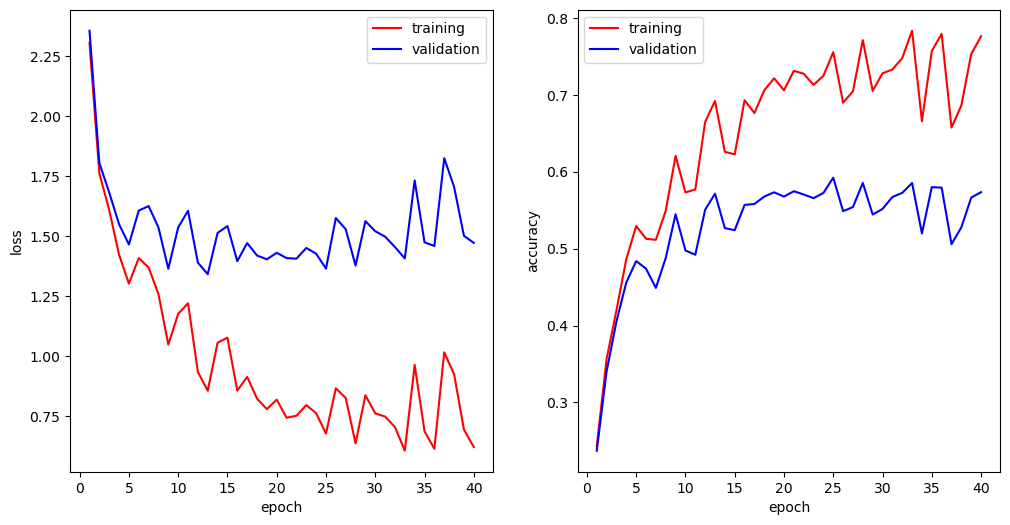

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.4904, Accuracy = 0.8110
client 2 : Loss = 0.1727, Accuracy = 0.9308
client 3 : Loss = 0.2498, Accuracy = 0.9095
client 4 : Loss = 0.3578, Accuracy = 0.8670
client 5 : Loss = 0.1855, Accuracy = 0.9323
client 6 : Loss = 0.0929, Accuracy = 0.9695
client 7 : Loss = 0.4267, Accuracy = 0.8401
client 8 : Loss = 0.4879, Accuracy = 0.7912

Server :
    - training loss = 2.0705
    - training accuracy = 0.2787
    - validation loss = 2.0886
    - validation accuracy = 0.2736
        
>>> Round 2 ...
client 1 : Loss = 0.3445, Accuracy = 0.8676
client 2 : Loss = 0.1056, Accuracy = 0.9616
client 3 : Loss = 0.1709, Accuracy = 0.9393
client 4 : Loss = 0.2343, Accuracy = 0.9134
client 5 : Loss = 0.4827, Accuracy = 0.8574
client 6 : Loss = 0.0636, Accuracy = 0.9811
cli

client 6 : Loss = 0.0086, Accuracy = 0.9994
client 7 : Loss = 0.0214, Accuracy = 0.9960
client 8 : Loss = 0.0109, Accuracy = 0.9976

Server :
    - training loss = 0.7579
    - training accuracy = 0.7311
    - validation loss = 1.4767
    - validation accuracy = 0.5656
        
>>> Round 17 ...
client 1 : Loss = 0.0130, Accuracy = 0.9965
client 2 : Loss = 0.0076, Accuracy = 0.9984
client 3 : Loss = 0.0183, Accuracy = 0.9966
client 4 : Loss = 0.0250, Accuracy = 0.9927
client 5 : Loss = 0.1071, Accuracy = 0.9623
client 6 : Loss = 0.0118, Accuracy = 0.9976
client 7 : Loss = 0.0246, Accuracy = 0.9932
client 8 : Loss = 0.0110, Accuracy = 0.9972

Server :
    - training loss = 0.7207
    - training accuracy = 0.7434
    - validation loss = 1.4610
    - validation accuracy = 0.5719
        
>>> Round 18 ...
client 1 : Loss = 0.0116, Accuracy = 0.9977
client 2 : Loss = 0.0101, Accuracy = 0.9984
client 3 : Loss = 0.0104, Accuracy = 0.9986
client 4 : Loss = 0.0156, Accuracy = 0.9956
client 5 : L

client 5 : Loss = 0.4640, Accuracy = 0.9041
client 6 : Loss = 0.0046, Accuracy = 0.9988
client 7 : Loss = 0.0059, Accuracy = 0.9988
client 8 : Loss = 0.0018, Accuracy = 0.9998

Server :
    - training loss = 0.5639
    - training accuracy = 0.8019
    - validation loss = 1.5891
    - validation accuracy = 0.5675
        
>>> Round 33 ...
client 1 : Loss = 0.0039, Accuracy = 0.9997
client 2 : Loss = 0.0045, Accuracy = 0.9991
client 3 : Loss = 0.0166, Accuracy = 0.9942
client 4 : Loss = 0.0026, Accuracy = 0.9998
client 5 : Loss = 0.2470, Accuracy = 0.9289
client 6 : Loss = 0.0050, Accuracy = 1.0000
client 7 : Loss = 0.0135, Accuracy = 0.9971
client 8 : Loss = 0.0026, Accuracy = 0.9995

Server :
    - training loss = 0.5689
    - training accuracy = 0.7996
    - validation loss = 1.5885
    - validation accuracy = 0.5670
        
>>> Round 34 ...
client 1 : Loss = 0.0058, Accuracy = 0.9991
client 2 : Loss = 0.0050, Accuracy = 0.9984
client 3 : Loss = 0.0057, Accuracy = 0.9986
client 4 : L

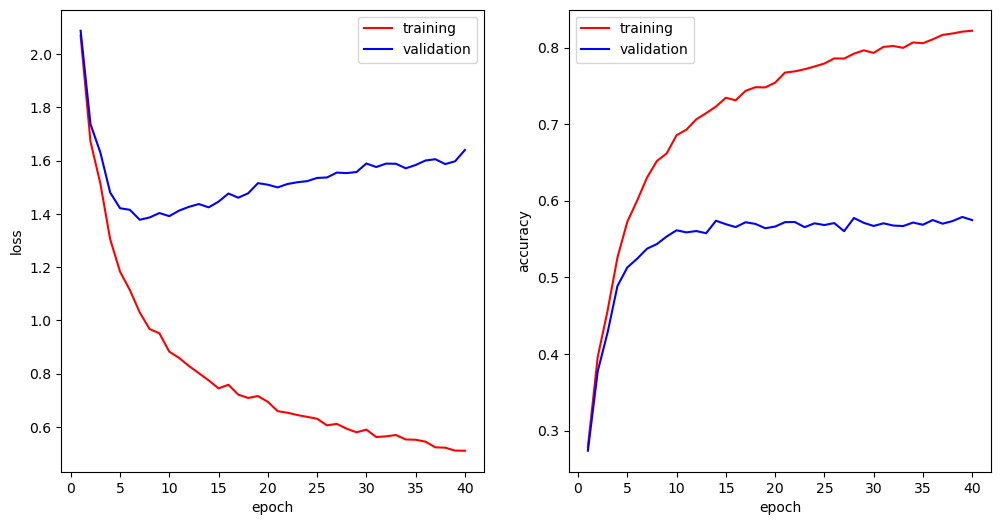

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.4585, Accuracy = 0.8235
client 2 : Loss = 0.1544, Accuracy = 0.9392
client 3 : Loss = 0.2518, Accuracy = 0.9060
client 4 : Loss = 0.4532, Accuracy = 0.8355
client 5 : Loss = 0.2779, Accuracy = 0.9084
client 6 : Loss = 0.0901, Accuracy = 0.9690
client 7 : Loss = 0.3778, Accuracy = 0.8625
client 8 : Loss = 0.4676, Accuracy = 0.7967

Server :
    - training loss = 2.2766
    - training accuracy = 0.2518
    - validation loss = 2.2959
    - validation accuracy = 0.2449
        
>>> Round 2 ...
client 1 : Loss = 0.3507, Accuracy = 0.8649
client 2 : Loss = 0.1012, Accuracy = 0.9625
client 3 : Loss = 0.1639, Accuracy = 0.9376
client 4 : Loss = 0.3085, Accuracy = 0.8881
client 5 : Loss = 0.1353, Accuracy = 0.9554
client 6 : Loss = 0.0538, Accuracy = 0.9872
cli

client 6 : Loss = 0.0094, Accuracy = 0.9982
client 7 : Loss = 0.0208, Accuracy = 0.9956
client 8 : Loss = 0.0121, Accuracy = 0.9974

Server :
    - training loss = 0.7183
    - training accuracy = 0.7419
    - validation loss = 1.3992
    - validation accuracy = 0.5777
        
>>> Round 17 ...
client 1 : Loss = 0.0133, Accuracy = 0.9973
client 2 : Loss = 0.0072, Accuracy = 0.9989
client 3 : Loss = 0.0149, Accuracy = 0.9973
client 4 : Loss = 0.0057, Accuracy = 0.9995
client 5 : Loss = 0.2226, Accuracy = 0.9417
client 6 : Loss = 0.0142, Accuracy = 0.9976
client 7 : Loss = 0.0164, Accuracy = 0.9976
client 8 : Loss = 0.0081, Accuracy = 0.9985

Server :
    - training loss = 0.6828
    - training accuracy = 0.7576
    - validation loss = 1.3905
    - validation accuracy = 0.5750
        
>>> Round 18 ...
client 1 : Loss = 0.0132, Accuracy = 0.9971
client 2 : Loss = 0.0137, Accuracy = 0.9961
client 3 : Loss = 0.0125, Accuracy = 0.9976
client 4 : Loss = 0.0154, Accuracy = 0.9961
client 5 : L

client 5 : Loss = 0.0732, Accuracy = 0.9766
client 6 : Loss = 0.0044, Accuracy = 0.9994
client 7 : Loss = 0.0080, Accuracy = 0.9988
client 8 : Loss = 0.0025, Accuracy = 0.9998

Server :
    - training loss = 0.5130
    - training accuracy = 0.8203
    - validation loss = 1.4499
    - validation accuracy = 0.5855
        
>>> Round 33 ...
client 1 : Loss = 0.0064, Accuracy = 0.9986
client 2 : Loss = 0.0036, Accuracy = 0.9998
client 3 : Loss = 0.0086, Accuracy = 0.9983
client 4 : Loss = 0.0021, Accuracy = 0.9999
client 5 : Loss = 0.0093, Accuracy = 0.9977
client 6 : Loss = 0.0081, Accuracy = 0.9988
client 7 : Loss = 0.0105, Accuracy = 0.9976
client 8 : Loss = 0.0037, Accuracy = 0.9993

Server :
    - training loss = 0.5011
    - training accuracy = 0.8228
    - validation loss = 1.4538
    - validation accuracy = 0.5911
        
>>> Round 34 ...
client 1 : Loss = 0.0041, Accuracy = 0.9996
client 2 : Loss = 0.0048, Accuracy = 0.9986
client 3 : Loss = 0.0079, Accuracy = 0.9980
client 4 : L

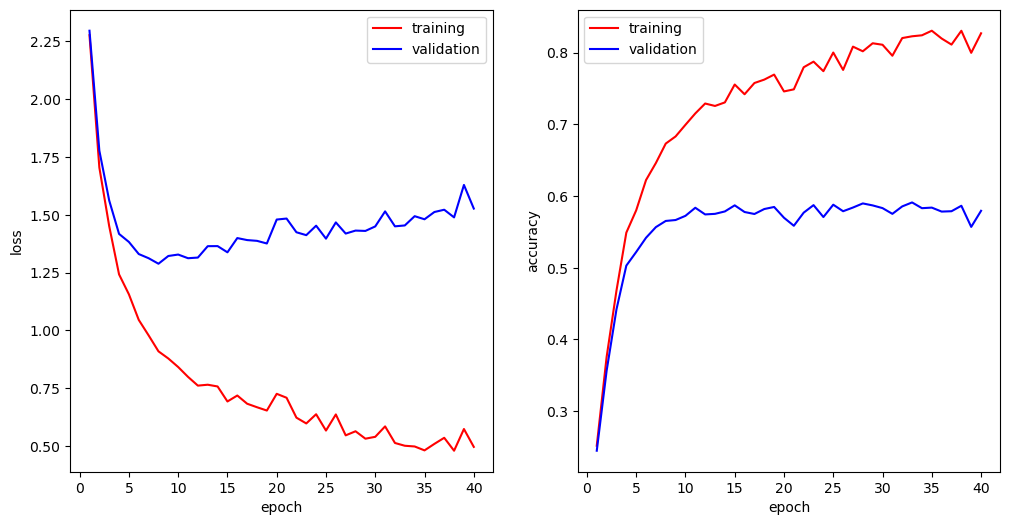

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.4850, Accuracy = 0.8089
client 2 : Loss = 0.1542, Accuracy = 0.9403
client 3 : Loss = 0.4639, Accuracy = 0.8465
client 4 : Loss = 0.3160, Accuracy = 0.8860
client 5 : Loss = 0.2960, Accuracy = 0.8990
client 6 : Loss = 0.0923, Accuracy = 0.9708
client 7 : Loss = 0.3998, Accuracy = 0.8525
client 8 : Loss = 0.4833, Accuracy = 0.7904

Server :
    - training loss = 2.1086
    - training accuracy = 0.2594
    - validation loss = 2.1412
    - validation accuracy = 0.2397
        
>>> Round 2 ...
client 1 : Loss = 0.3711, Accuracy = 0.8604
client 2 : Loss = 0.0973, Accuracy = 0.9639
client 3 : Loss = 0.2568, Accuracy = 0.9018
client 4 : Loss = 0.2074, Accuracy = 0.9239
client 5 : Loss = 0.2648, Accuracy = 0.9109
client 6 : Loss = 0.0552, Accuracy = 0.9854
cli

client 6 : Loss = 0.0084, Accuracy = 0.9992
client 7 : Loss = 0.0221, Accuracy = 0.9949
client 8 : Loss = 0.0119, Accuracy = 0.9963

Server :
    - training loss = 0.7314
    - training accuracy = 0.7408
    - validation loss = 1.4237
    - validation accuracy = 0.5630
        
>>> Round 17 ...
client 1 : Loss = 0.0130, Accuracy = 0.9975
client 2 : Loss = 0.0103, Accuracy = 0.9979
client 3 : Loss = 0.1814, Accuracy = 0.9443
client 4 : Loss = 0.0193, Accuracy = 0.9948
client 5 : Loss = 0.0617, Accuracy = 0.9826
client 6 : Loss = 0.0093, Accuracy = 0.9988
client 7 : Loss = 0.0209, Accuracy = 0.9939
client 8 : Loss = 0.0227, Accuracy = 0.9934

Server :
    - training loss = 0.7117
    - training accuracy = 0.7484
    - validation loss = 1.4389
    - validation accuracy = 0.5665
        
>>> Round 18 ...
client 1 : Loss = 0.0123, Accuracy = 0.9975
client 2 : Loss = 0.0098, Accuracy = 0.9974
client 3 : Loss = 0.0597, Accuracy = 0.9820
client 4 : Loss = 0.0089, Accuracy = 0.9979
client 5 : L

client 5 : Loss = 0.5334, Accuracy = 0.8940
client 6 : Loss = 0.0085, Accuracy = 0.9974
client 7 : Loss = 0.0109, Accuracy = 0.9976
client 8 : Loss = 0.0056, Accuracy = 0.9988

Server :
    - training loss = 0.5773
    - training accuracy = 0.7983
    - validation loss = 1.5413
    - validation accuracy = 0.5680
        
>>> Round 33 ...
client 1 : Loss = 0.0043, Accuracy = 0.9994
client 2 : Loss = 0.0045, Accuracy = 0.9998
client 3 : Loss = 0.0620, Accuracy = 0.9766
client 4 : Loss = 0.0046, Accuracy = 0.9989
client 5 : Loss = 0.0081, Accuracy = 0.9986
client 6 : Loss = 0.0037, Accuracy = 1.0000
client 7 : Loss = 0.0068, Accuracy = 0.9988
client 8 : Loss = 0.0029, Accuracy = 0.9995

Server :
    - training loss = 0.5626
    - training accuracy = 0.8033
    - validation loss = 1.5379
    - validation accuracy = 0.5684
        
>>> Round 34 ...
client 1 : Loss = 0.0045, Accuracy = 0.9996
client 2 : Loss = 0.0061, Accuracy = 0.9984
client 3 : Loss = 0.0254, Accuracy = 0.9929
client 4 : L

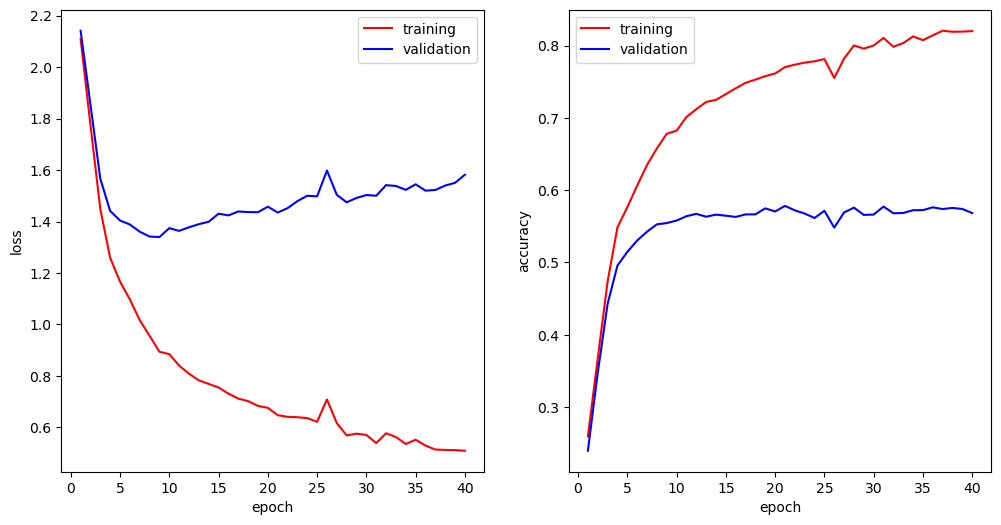

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.4864, Accuracy = 0.8144
client 2 : Loss = 0.1515, Accuracy = 0.9376
client 3 : Loss = 0.3090, Accuracy = 0.8858
client 4 : Loss = 0.3525, Accuracy = 0.8678
client 5 : Loss = 0.1159, Accuracy = 0.9613
client 6 : Loss = 0.1003, Accuracy = 0.9678
client 7 : Loss = 0.4237, Accuracy = 0.8458
client 8 : Loss = 0.5448, Accuracy = 0.7779

Server :
    - training loss = 2.2012
    - training accuracy = 0.2628
    - validation loss = 2.2335
    - validation accuracy = 0.2501
        
>>> Round 2 ...
client 1 : Loss = 0.3694, Accuracy = 0.8594
client 2 : Loss = 0.0940, Accuracy = 0.9690
client 3 : Loss = 0.1700, Accuracy = 0.9413
client 4 : Loss = 0.2070, Accuracy = 0.9218
client 5 : Loss = 0.0678, Accuracy = 0.9804
client 6 : Loss = 0.0621, Accuracy = 0.9786
cli

client 6 : Loss = 0.0078, Accuracy = 0.9994
client 7 : Loss = 0.0231, Accuracy = 0.9958
client 8 : Loss = 0.0140, Accuracy = 0.9963

Server :
    - training loss = 0.7376
    - training accuracy = 0.7402
    - validation loss = 1.4486
    - validation accuracy = 0.5616
        
>>> Round 17 ...
client 1 : Loss = 0.0126, Accuracy = 0.9977
client 2 : Loss = 0.0082, Accuracy = 0.9984
client 3 : Loss = 0.0138, Accuracy = 0.9973
client 4 : Loss = 0.0086, Accuracy = 0.9980
client 5 : Loss = 0.0120, Accuracy = 0.9971
client 6 : Loss = 0.0070, Accuracy = 1.0000
client 7 : Loss = 0.0194, Accuracy = 0.9956
client 8 : Loss = 0.0083, Accuracy = 0.9983

Server :
    - training loss = 0.7210
    - training accuracy = 0.7458
    - validation loss = 1.4501
    - validation accuracy = 0.5672
        
>>> Round 18 ...
client 1 : Loss = 0.0107, Accuracy = 0.9984
client 2 : Loss = 0.0076, Accuracy = 0.9982
client 3 : Loss = 0.0145, Accuracy = 0.9976
client 4 : Loss = 0.0066, Accuracy = 0.9985
client 5 : L

client 5 : Loss = 0.0029, Accuracy = 1.0000
client 6 : Loss = 0.0058, Accuracy = 0.9994
client 7 : Loss = 0.0118, Accuracy = 0.9983
client 8 : Loss = 0.0016, Accuracy = 1.0000

Server :
    - training loss = 0.5653
    - training accuracy = 0.8035
    - validation loss = 1.5568
    - validation accuracy = 0.5676
        
>>> Round 33 ...
client 1 : Loss = 0.0041, Accuracy = 0.9994
client 2 : Loss = 0.0036, Accuracy = 0.9998
client 3 : Loss = 0.0081, Accuracy = 0.9986
client 4 : Loss = 0.0022, Accuracy = 0.9999
client 5 : Loss = 0.0050, Accuracy = 0.9995
client 6 : Loss = 0.0070, Accuracy = 0.9982
client 7 : Loss = 0.0094, Accuracy = 0.9970
client 8 : Loss = 0.0016, Accuracy = 0.9999

Server :
    - training loss = 0.5611
    - training accuracy = 0.8065
    - validation loss = 1.5738
    - validation accuracy = 0.5618
        
>>> Round 34 ...
client 1 : Loss = 0.0044, Accuracy = 0.9991
client 2 : Loss = 0.0045, Accuracy = 0.9986
client 3 : Loss = 0.0090, Accuracy = 0.9970
client 4 : L

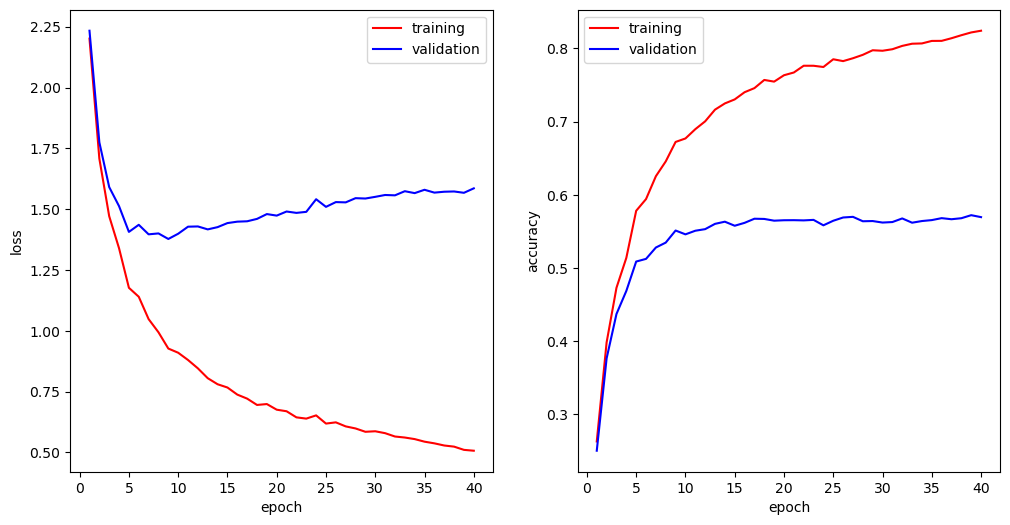

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.7647, Accuracy = 0.7041
client 2 : Loss = 0.2653, Accuracy = 0.8922
client 3 : Loss = 0.4401, Accuracy = 0.8463
client 4 : Loss = 0.5115, Accuracy = 0.8035
client 5 : Loss = 0.3434, Accuracy = 0.8842
client 6 : Loss = 0.2759, Accuracy = 0.9184
client 7 : Loss = 0.6537, Accuracy = 0.7525
client 8 : Loss = 0.5862, Accuracy = 0.7521

Server :
    - training loss = 2.1194
    - training accuracy = 0.2526
    - validation loss = 2.1513
    - validation accuracy = 0.2479
        
>>> Round 2 ...
client 1 : Loss = 0.6725, Accuracy = 0.7352
client 2 : Loss = 0.2244, Accuracy = 0.9057
client 3 : Loss = 0.3797, Accuracy = 0.8673
client 4 : Loss = 0.4764, Accuracy = 0.8244
client 5 : Loss = 0.3078, Accuracy = 0.8974
client 6 : Loss = 0.2320, Accuracy = 0.9277
cli

client 6 : Loss = 0.1290, Accuracy = 0.9646
client 7 : Loss = 0.2494, Accuracy = 0.9144
client 8 : Loss = 0.1431, Accuracy = 0.9521

Server :
    - training loss = 1.1705
    - training accuracy = 0.5759
    - validation loss = 1.4913
    - validation accuracy = 0.4829
        
>>> Round 17 ...
client 1 : Loss = 0.3874, Accuracy = 0.8611
client 2 : Loss = 0.0989, Accuracy = 0.9692
client 3 : Loss = 0.1650, Accuracy = 0.9469
client 4 : Loss = 0.1082, Accuracy = 0.9690
client 5 : Loss = 0.1328, Accuracy = 0.9604
client 6 : Loss = 0.1302, Accuracy = 0.9597
client 7 : Loss = 0.2231, Accuracy = 0.9258
client 8 : Loss = 0.1302, Accuracy = 0.9561

Server :
    - training loss = 1.1168
    - training accuracy = 0.6028
    - validation loss = 1.4466
    - validation accuracy = 0.4995
        
>>> Round 18 ...
client 1 : Loss = 0.3733, Accuracy = 0.8693
client 2 : Loss = 0.1036, Accuracy = 0.9647
client 3 : Loss = 0.1583, Accuracy = 0.9492
client 4 : Loss = 0.1247, Accuracy = 0.9595
client 5 : L

client 5 : Loss = 0.0859, Accuracy = 0.9766
client 6 : Loss = 0.0852, Accuracy = 0.9769
client 7 : Loss = 0.1271, Accuracy = 0.9604
client 8 : Loss = 0.0461, Accuracy = 0.9879

Server :
    - training loss = 0.9392
    - training accuracy = 0.6666
    - validation loss = 1.4834
    - validation accuracy = 0.5129
        
>>> Round 33 ...
client 1 : Loss = 0.2535, Accuracy = 0.9105
client 2 : Loss = 0.0510, Accuracy = 0.9863
client 3 : Loss = 0.0936, Accuracy = 0.9747
client 4 : Loss = 0.0474, Accuracy = 0.9896
client 5 : Loss = 0.0790, Accuracy = 0.9824
client 6 : Loss = 0.0871, Accuracy = 0.9730
client 7 : Loss = 0.1160, Accuracy = 0.9667
client 8 : Loss = 0.0475, Accuracy = 0.9868

Server :
    - training loss = 0.9013
    - training accuracy = 0.6800
    - validation loss = 1.4603
    - validation accuracy = 0.5165
        
>>> Round 34 ...
client 1 : Loss = 0.3372, Accuracy = 0.8882
client 2 : Loss = 0.0530, Accuracy = 0.9851
client 3 : Loss = 0.0829, Accuracy = 0.9774
client 4 : L

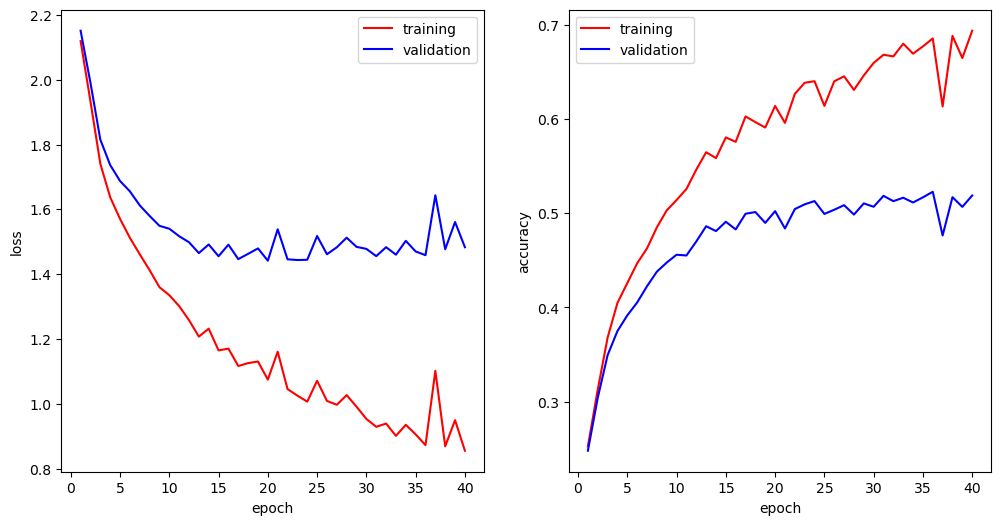

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.6912, Accuracy = 0.7320
client 2 : Loss = 0.2620, Accuracy = 0.8951
client 3 : Loss = 0.4428, Accuracy = 0.8512
client 4 : Loss = 0.5176, Accuracy = 0.7962
client 5 : Loss = 0.3390, Accuracy = 0.8689
client 6 : Loss = 0.2920, Accuracy = 0.9095
client 7 : Loss = 0.6683, Accuracy = 0.7544
client 8 : Loss = 0.5658, Accuracy = 0.7550

Server :
    - training loss = 2.1580
    - training accuracy = 0.2388
    - validation loss = 2.1923
    - validation accuracy = 0.2294
        
>>> Round 2 ...
client 1 : Loss = 0.6132, Accuracy = 0.7639
client 2 : Loss = 0.2307, Accuracy = 0.9083
client 3 : Loss = 0.3799, Accuracy = 0.8774
client 4 : Loss = 0.4309, Accuracy = 0.8355
client 5 : Loss = 0.2897, Accuracy = 0.9076
client 6 : Loss = 0.2534, Accuracy = 0.9234
cli

client 6 : Loss = 0.1220, Accuracy = 0.9636
client 7 : Loss = 0.2420, Accuracy = 0.9199
client 8 : Loss = 0.1346, Accuracy = 0.9561

Server :
    - training loss = 1.1679
    - training accuracy = 0.5760
    - validation loss = 1.5098
    - validation accuracy = 0.4771
        
>>> Round 17 ...
client 1 : Loss = 0.1933, Accuracy = 0.9373
client 2 : Loss = 0.1014, Accuracy = 0.9670
client 3 : Loss = 0.1721, Accuracy = 0.9431
client 4 : Loss = 0.1037, Accuracy = 0.9709
client 5 : Loss = 0.1451, Accuracy = 0.9517
client 6 : Loss = 0.1213, Accuracy = 0.9601
client 7 : Loss = 0.2285, Accuracy = 0.9257
client 8 : Loss = 0.1261, Accuracy = 0.9596

Server :
    - training loss = 1.1392
    - training accuracy = 0.5825
    - validation loss = 1.5007
    - validation accuracy = 0.4783
        
>>> Round 18 ...
client 1 : Loss = 0.1892, Accuracy = 0.9380
client 2 : Loss = 0.0918, Accuracy = 0.9712
client 3 : Loss = 0.1524, Accuracy = 0.9499
client 4 : Loss = 0.1070, Accuracy = 0.9662
client 5 : L

client 5 : Loss = 0.1748, Accuracy = 0.9540
client 6 : Loss = 0.0679, Accuracy = 0.9828
client 7 : Loss = 0.1103, Accuracy = 0.9685
client 8 : Loss = 0.0420, Accuracy = 0.9896

Server :
    - training loss = 0.9488
    - training accuracy = 0.6558
    - validation loss = 1.5542
    - validation accuracy = 0.4955
        
>>> Round 33 ...
client 1 : Loss = 0.0836, Accuracy = 0.9765
client 2 : Loss = 0.0512, Accuracy = 0.9864
client 3 : Loss = 0.0809, Accuracy = 0.9760
client 4 : Loss = 0.0436, Accuracy = 0.9891
client 5 : Loss = 0.1177, Accuracy = 0.9585
client 6 : Loss = 0.0817, Accuracy = 0.9731
client 7 : Loss = 0.1124, Accuracy = 0.9681
client 8 : Loss = 0.0414, Accuracy = 0.9906

Server :
    - training loss = 0.9329
    - training accuracy = 0.6619
    - validation loss = 1.5483
    - validation accuracy = 0.4948
        
>>> Round 34 ...
client 1 : Loss = 0.0706, Accuracy = 0.9836
client 2 : Loss = 0.0570, Accuracy = 0.9833
client 3 : Loss = 0.0839, Accuracy = 0.9746
client 4 : L

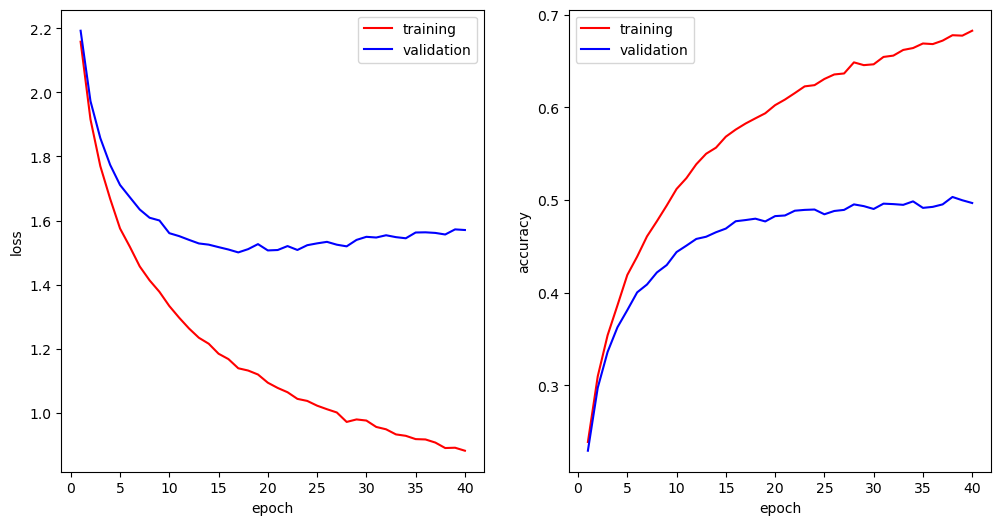

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.6600, Accuracy = 0.7382
client 2 : Loss = 0.2457, Accuracy = 0.9031
client 3 : Loss = 0.4075, Accuracy = 0.8606
client 4 : Loss = 0.5352, Accuracy = 0.7956
client 5 : Loss = 0.3406, Accuracy = 0.8906
client 6 : Loss = 0.2656, Accuracy = 0.9273
client 7 : Loss = 0.6338, Accuracy = 0.7757
client 8 : Loss = 0.5738, Accuracy = 0.7510

Server :
    - training loss = 2.1327
    - training accuracy = 0.2524
    - validation loss = 2.1710
    - validation accuracy = 0.2404
        
>>> Round 2 ...
client 1 : Loss = 0.5901, Accuracy = 0.7651
client 2 : Loss = 0.2389, Accuracy = 0.9053
client 3 : Loss = 0.3623, Accuracy = 0.8685
client 4 : Loss = 0.4518, Accuracy = 0.8287
client 5 : Loss = 0.3465, Accuracy = 0.8840
client 6 : Loss = 0.2331, Accuracy = 0.9313
cli

client 6 : Loss = 0.1410, Accuracy = 0.9525
client 7 : Loss = 0.2195, Accuracy = 0.9266
client 8 : Loss = 0.1365, Accuracy = 0.9550

Server :
    - training loss = 1.1307
    - training accuracy = 0.5915
    - validation loss = 1.4892
    - validation accuracy = 0.4840
        
>>> Round 17 ...
client 1 : Loss = 0.1785, Accuracy = 0.9410
client 2 : Loss = 0.1017, Accuracy = 0.9632
client 3 : Loss = 0.1570, Accuracy = 0.9502
client 4 : Loss = 0.1047, Accuracy = 0.9684
client 5 : Loss = 0.1745, Accuracy = 0.9374
client 6 : Loss = 0.1248, Accuracy = 0.9625
client 7 : Loss = 0.2085, Accuracy = 0.9302
client 8 : Loss = 0.1226, Accuracy = 0.9608

Server :
    - training loss = 1.1195
    - training accuracy = 0.5957
    - validation loss = 1.4952
    - validation accuracy = 0.4877
        
>>> Round 18 ...
client 1 : Loss = 0.1666, Accuracy = 0.9465
client 2 : Loss = 0.0925, Accuracy = 0.9700
client 3 : Loss = 0.1410, Accuracy = 0.9532
client 4 : Loss = 0.0934, Accuracy = 0.9745
client 5 : L

client 5 : Loss = 0.1407, Accuracy = 0.9527
client 6 : Loss = 0.0702, Accuracy = 0.9828
client 7 : Loss = 0.0959, Accuracy = 0.9751
client 8 : Loss = 0.0406, Accuracy = 0.9912

Server :
    - training loss = 0.9218
    - training accuracy = 0.6721
    - validation loss = 1.5196
    - validation accuracy = 0.5027
        
>>> Round 33 ...
client 1 : Loss = 0.0714, Accuracy = 0.9831
client 2 : Loss = 0.0484, Accuracy = 0.9870
client 3 : Loss = 0.0786, Accuracy = 0.9768
client 4 : Loss = 0.0572, Accuracy = 0.9852
client 5 : Loss = 0.1448, Accuracy = 0.9554
client 6 : Loss = 0.0738, Accuracy = 0.9772
client 7 : Loss = 0.0999, Accuracy = 0.9737
client 8 : Loss = 0.0393, Accuracy = 0.9910

Server :
    - training loss = 0.9059
    - training accuracy = 0.6778
    - validation loss = 1.5210
    - validation accuracy = 0.5030
        
>>> Round 34 ...
client 1 : Loss = 0.0653, Accuracy = 0.9865
client 2 : Loss = 0.0452, Accuracy = 0.9874
client 3 : Loss = 0.0874, Accuracy = 0.9736
client 4 : L

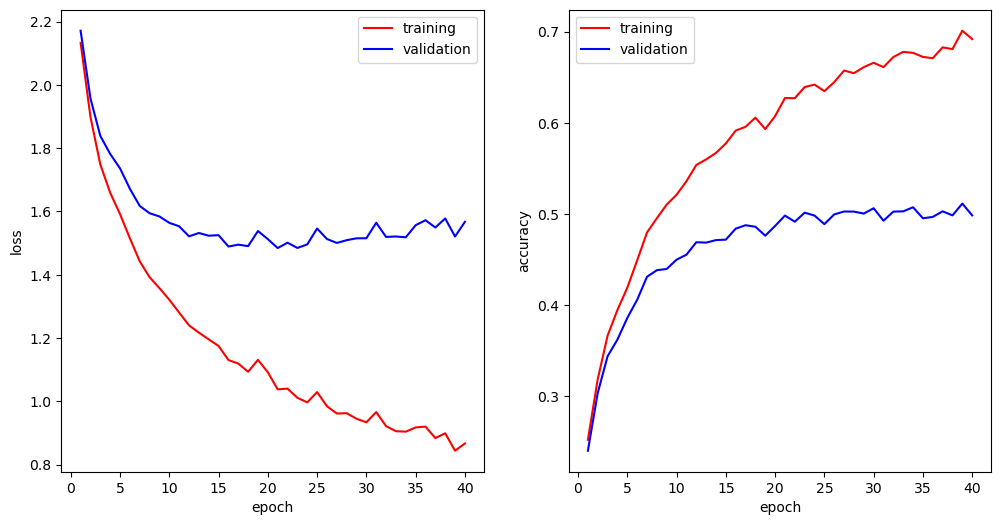

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.6529, Accuracy = 0.7425
client 2 : Loss = 0.2667, Accuracy = 0.8918
client 3 : Loss = 0.4663, Accuracy = 0.8312
client 4 : Loss = 0.5024, Accuracy = 0.8004
client 5 : Loss = 0.3877, Accuracy = 0.8574
client 6 : Loss = 0.2843, Accuracy = 0.9124
client 7 : Loss = 0.6537, Accuracy = 0.7671
client 8 : Loss = 0.5653, Accuracy = 0.7610

Server :
    - training loss = 2.1563
    - training accuracy = 0.2377
    - validation loss = 2.1986
    - validation accuracy = 0.2329
        
>>> Round 2 ...
client 1 : Loss = 0.5796, Accuracy = 0.7731
client 2 : Loss = 0.2419, Accuracy = 0.9033
client 3 : Loss = 0.4085, Accuracy = 0.8601
client 4 : Loss = 0.4348, Accuracy = 0.8359
client 5 : Loss = 0.3265, Accuracy = 0.8793
client 6 : Loss = 0.2485, Accuracy = 0.9275
cli

client 6 : Loss = 0.1345, Accuracy = 0.9566
client 7 : Loss = 0.2138, Accuracy = 0.9324
client 8 : Loss = 0.1252, Accuracy = 0.9619

Server :
    - training loss = 1.1505
    - training accuracy = 0.5809
    - validation loss = 1.5130
    - validation accuracy = 0.4791
        
>>> Round 17 ...
client 1 : Loss = 0.1767, Accuracy = 0.9423
client 2 : Loss = 0.0907, Accuracy = 0.9711
client 3 : Loss = 0.1857, Accuracy = 0.9321
client 4 : Loss = 0.0977, Accuracy = 0.9708
client 5 : Loss = 0.1380, Accuracy = 0.9518
client 6 : Loss = 0.1418, Accuracy = 0.9505
client 7 : Loss = 0.1998, Accuracy = 0.9351
client 8 : Loss = 0.1156, Accuracy = 0.9642

Server :
    - training loss = 1.1303
    - training accuracy = 0.5865
    - validation loss = 1.5076
    - validation accuracy = 0.4777
        
>>> Round 18 ...
client 1 : Loss = 0.1640, Accuracy = 0.9492
client 2 : Loss = 0.0931, Accuracy = 0.9685
client 3 : Loss = 0.1716, Accuracy = 0.9409
client 4 : Loss = 0.0855, Accuracy = 0.9779
client 5 : L

client 5 : Loss = 0.0851, Accuracy = 0.9761
client 6 : Loss = 0.0753, Accuracy = 0.9771
client 7 : Loss = 0.0925, Accuracy = 0.9741
client 8 : Loss = 0.0427, Accuracy = 0.9902

Server :
    - training loss = 0.9359
    - training accuracy = 0.6605
    - validation loss = 1.5343
    - validation accuracy = 0.4930
        
>>> Round 33 ...
client 1 : Loss = 0.0728, Accuracy = 0.9839
client 2 : Loss = 0.0499, Accuracy = 0.9865
client 3 : Loss = 0.1044, Accuracy = 0.9671
client 4 : Loss = 0.0362, Accuracy = 0.9934
client 5 : Loss = 0.1152, Accuracy = 0.9628
client 6 : Loss = 0.0830, Accuracy = 0.9774
client 7 : Loss = 0.0945, Accuracy = 0.9761
client 8 : Loss = 0.0338, Accuracy = 0.9937

Server :
    - training loss = 0.9274
    - training accuracy = 0.6638
    - validation loss = 1.5468
    - validation accuracy = 0.4977
        
>>> Round 34 ...
client 1 : Loss = 0.0681, Accuracy = 0.9849
client 2 : Loss = 0.0521, Accuracy = 0.9856
client 3 : Loss = 0.0896, Accuracy = 0.9735
client 4 : L

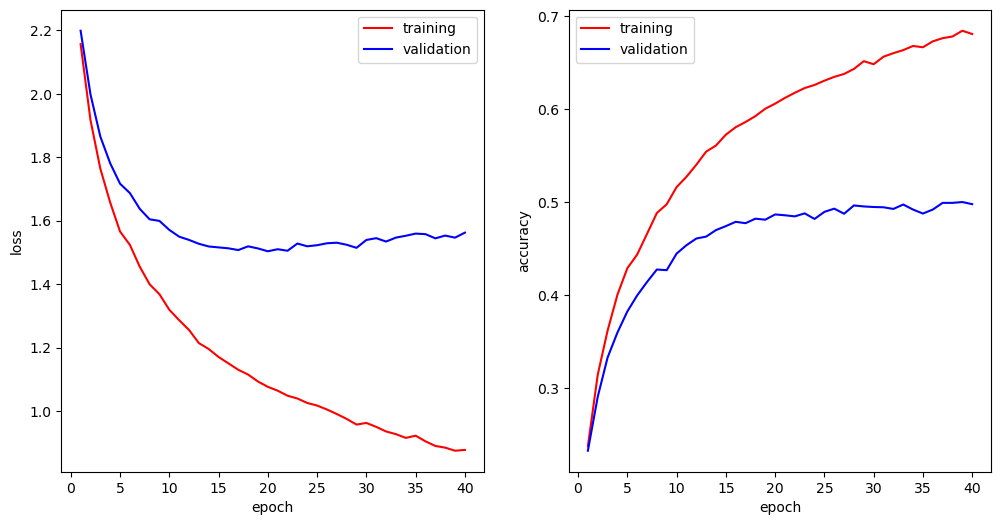

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.6683, Accuracy = 0.7352
client 2 : Loss = 0.2688, Accuracy = 0.8935
client 3 : Loss = 0.4213, Accuracy = 0.8590
client 4 : Loss = 0.5192, Accuracy = 0.8009
client 5 : Loss = 0.3117, Accuracy = 0.8889
client 6 : Loss = 0.3007, Accuracy = 0.9116
client 7 : Loss = 0.6290, Accuracy = 0.7721
client 8 : Loss = 0.5644, Accuracy = 0.7623

Server :
    - training loss = 2.1171
    - training accuracy = 0.2516
    - validation loss = 2.1819
    - validation accuracy = 0.2297
        
>>> Round 2 ...
client 1 : Loss = 0.6024, Accuracy = 0.7656
client 2 : Loss = 0.2500, Accuracy = 0.9010
client 3 : Loss = 0.3711, Accuracy = 0.8736
client 4 : Loss = 0.4425, Accuracy = 0.8299
client 5 : Loss = 0.2558, Accuracy = 0.9100
client 6 : Loss = 0.2573, Accuracy = 0.9211
cli

client 6 : Loss = 0.1361, Accuracy = 0.9562
client 7 : Loss = 0.2202, Accuracy = 0.9261
client 8 : Loss = 0.1351, Accuracy = 0.9580

Server :
    - training loss = 1.1421
    - training accuracy = 0.5875
    - validation loss = 1.5266
    - validation accuracy = 0.4682
        
>>> Round 17 ...
client 1 : Loss = 0.1781, Accuracy = 0.9447
client 2 : Loss = 0.1109, Accuracy = 0.9631
client 3 : Loss = 0.1369, Accuracy = 0.9575
client 4 : Loss = 0.0955, Accuracy = 0.9734
client 5 : Loss = 0.1035, Accuracy = 0.9721
client 6 : Loss = 0.1109, Accuracy = 0.9698
client 7 : Loss = 0.2067, Accuracy = 0.9332
client 8 : Loss = 0.1226, Accuracy = 0.9631

Server :
    - training loss = 1.1228
    - training accuracy = 0.5967
    - validation loss = 1.5243
    - validation accuracy = 0.4680
        
>>> Round 18 ...
client 1 : Loss = 0.1662, Accuracy = 0.9497
client 2 : Loss = 0.1016, Accuracy = 0.9642
client 3 : Loss = 0.1608, Accuracy = 0.9515
client 4 : Loss = 0.0857, Accuracy = 0.9756
client 5 : L

client 5 : Loss = 0.0748, Accuracy = 0.9813
client 6 : Loss = 0.0726, Accuracy = 0.9790
client 7 : Loss = 0.1004, Accuracy = 0.9732
client 8 : Loss = 0.0428, Accuracy = 0.9888

Server :
    - training loss = 0.9110
    - training accuracy = 0.6749
    - validation loss = 1.5467
    - validation accuracy = 0.4848
        
>>> Round 33 ...
client 1 : Loss = 0.0698, Accuracy = 0.9868
client 2 : Loss = 0.0530, Accuracy = 0.9845
client 3 : Loss = 0.0773, Accuracy = 0.9794
client 4 : Loss = 0.0361, Accuracy = 0.9939
client 5 : Loss = 0.0629, Accuracy = 0.9853
client 6 : Loss = 0.0786, Accuracy = 0.9786
client 7 : Loss = 0.0972, Accuracy = 0.9756
client 8 : Loss = 0.0389, Accuracy = 0.9911

Server :
    - training loss = 0.9105
    - training accuracy = 0.6722
    - validation loss = 1.5591
    - validation accuracy = 0.4865
        
>>> Round 34 ...
client 1 : Loss = 0.0666, Accuracy = 0.9859
client 2 : Loss = 0.0480, Accuracy = 0.9881
client 3 : Loss = 0.0804, Accuracy = 0.9800
client 4 : L

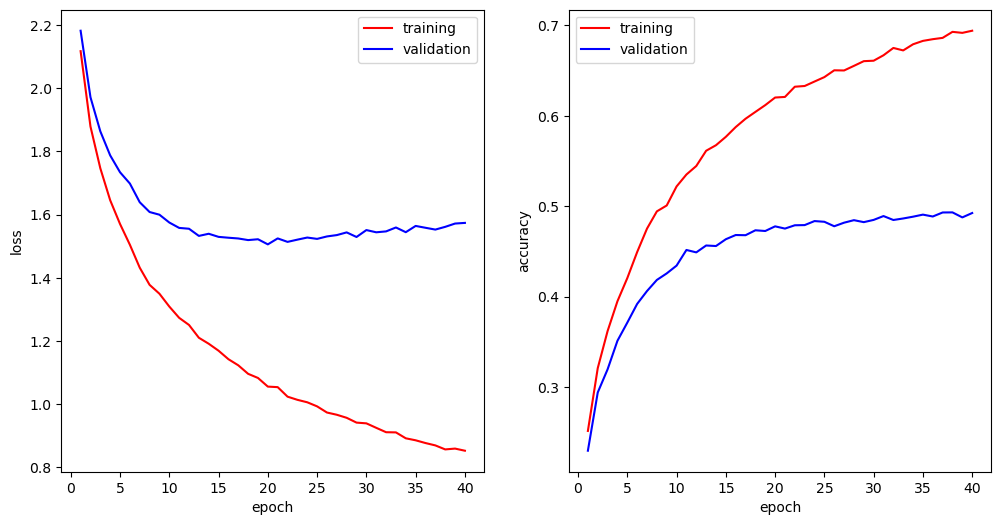

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 1.2206, Accuracy = 0.5497
client 2 : Loss = 0.6130, Accuracy = 0.7860
client 3 : Loss = 0.8972, Accuracy = 0.7484
client 4 : Loss = 1.0419, Accuracy = 0.5954
client 5 : Loss = 1.0061, Accuracy = 0.6893
client 6 : Loss = 0.7529, Accuracy = 0.8421
client 7 : Loss = 1.3394, Accuracy = 0.5732
client 8 : Loss = 0.9339, Accuracy = 0.6100

Server :
    - training loss = 2.3135
    - training accuracy = 0.1810
    - validation loss = 2.3286
    - validation accuracy = 0.1812
        
>>> Round 2 ...
client 1 : Loss = 1.1569, Accuracy = 0.5831
client 2 : Loss = 0.5879, Accuracy = 0.7914
client 3 : Loss = 0.8247, Accuracy = 0.7640
client 4 : Loss = 0.9858, Accuracy = 0.6098
client 5 : Loss = 0.9502, Accuracy = 0.7245
client 6 : Loss = 0.6470, Accuracy = 0.8484
cli

client 6 : Loss = 0.5401, Accuracy = 0.8644
client 7 : Loss = 0.8802, Accuracy = 0.7093
client 8 : Loss = 0.6635, Accuracy = 0.7230

Server :
    - training loss = 1.6621
    - training accuracy = 0.4012
    - validation loss = 1.7548
    - validation accuracy = 0.3648
        
>>> Round 17 ...
client 1 : Loss = 0.8495, Accuracy = 0.6757
client 2 : Loss = 0.4647, Accuracy = 0.8457
client 3 : Loss = 0.6268, Accuracy = 0.8187
client 4 : Loss = 0.6482, Accuracy = 0.7555
client 5 : Loss = 0.6437, Accuracy = 0.8173
client 6 : Loss = 0.5278, Accuracy = 0.8670
client 7 : Loss = 0.8691, Accuracy = 0.7124
client 8 : Loss = 0.6496, Accuracy = 0.7293

Server :
    - training loss = 1.6443
    - training accuracy = 0.4080
    - validation loss = 1.7457
    - validation accuracy = 0.3699
        
>>> Round 18 ...
client 1 : Loss = 0.8507, Accuracy = 0.6871
client 2 : Loss = 0.4625, Accuracy = 0.8397
client 3 : Loss = 0.6070, Accuracy = 0.8227
client 4 : Loss = 0.6385, Accuracy = 0.7640
client 5 : L

client 5 : Loss = 0.5648, Accuracy = 0.8476
client 6 : Loss = 0.4978, Accuracy = 0.8682
client 7 : Loss = 0.7452, Accuracy = 0.7507
client 8 : Loss = 0.5546, Accuracy = 0.7782

Server :
    - training loss = 1.4887
    - training accuracy = 0.4723
    - validation loss = 1.6290
    - validation accuracy = 0.4153
        
>>> Round 33 ...
client 1 : Loss = 0.7152, Accuracy = 0.7392
client 2 : Loss = 0.4188, Accuracy = 0.8643
client 3 : Loss = 0.5571, Accuracy = 0.8378
client 4 : Loss = 0.5119, Accuracy = 0.8215
client 5 : Loss = 0.5584, Accuracy = 0.8466
client 6 : Loss = 0.5024, Accuracy = 0.8660
client 7 : Loss = 0.7521, Accuracy = 0.7557
client 8 : Loss = 0.5466, Accuracy = 0.7809

Server :
    - training loss = 1.4803
    - training accuracy = 0.4759
    - validation loss = 1.6230
    - validation accuracy = 0.4153
        
>>> Round 34 ...
client 1 : Loss = 0.7083, Accuracy = 0.7331
client 2 : Loss = 0.4001, Accuracy = 0.8705
client 3 : Loss = 0.5612, Accuracy = 0.8366
client 4 : L

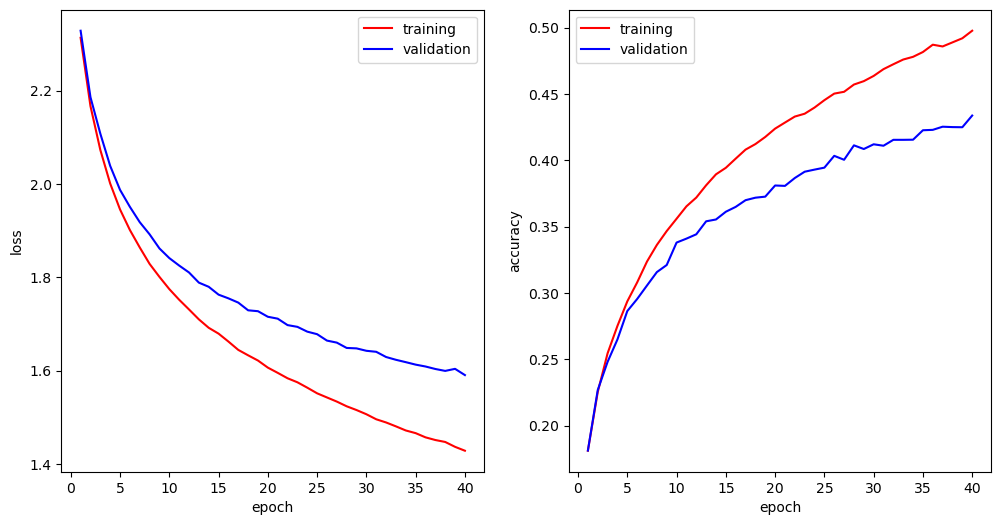

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 1.2223, Accuracy = 0.5419
client 2 : Loss = 0.6120, Accuracy = 0.7789
client 3 : Loss = 0.9321, Accuracy = 0.7416
client 4 : Loss = 1.0530, Accuracy = 0.6003
client 5 : Loss = 0.9879, Accuracy = 0.6863
client 6 : Loss = 0.7324, Accuracy = 0.8443
client 7 : Loss = 1.3510, Accuracy = 0.5742
client 8 : Loss = 0.9354, Accuracy = 0.6095

Server :
    - training loss = 2.3717
    - training accuracy = 0.1642
    - validation loss = 2.3860
    - validation accuracy = 0.1597
        
>>> Round 2 ...
client 1 : Loss = 1.1799, Accuracy = 0.5605
client 2 : Loss = 0.5929, Accuracy = 0.7954
client 3 : Loss = 0.8742, Accuracy = 0.7622
client 4 : Loss = 0.9913, Accuracy = 0.6259
client 5 : Loss = 0.8790, Accuracy = 0.7338
client 6 : Loss = 0.6798, Accuracy = 0.8502
cli

client 6 : Loss = 0.5175, Accuracy = 0.8739
client 7 : Loss = 0.8655, Accuracy = 0.7174
client 8 : Loss = 0.6611, Accuracy = 0.7254

Server :
    - training loss = 1.6744
    - training accuracy = 0.3961
    - validation loss = 1.7637
    - validation accuracy = 0.3641
        
>>> Round 17 ...
client 1 : Loss = 0.8501, Accuracy = 0.6790
client 2 : Loss = 0.4556, Accuracy = 0.8474
client 3 : Loss = 0.6211, Accuracy = 0.8210
client 4 : Loss = 0.6549, Accuracy = 0.7666
client 5 : Loss = 0.6126, Accuracy = 0.8183
client 6 : Loss = 0.5487, Accuracy = 0.8699
client 7 : Loss = 0.8605, Accuracy = 0.7209
client 8 : Loss = 0.6494, Accuracy = 0.7349

Server :
    - training loss = 1.6608
    - training accuracy = 0.4002
    - validation loss = 1.7409
    - validation accuracy = 0.3745
        
>>> Round 18 ...
client 1 : Loss = 0.8293, Accuracy = 0.6859
client 2 : Loss = 0.4469, Accuracy = 0.8525
client 3 : Loss = 0.6303, Accuracy = 0.8251
client 4 : Loss = 0.6324, Accuracy = 0.7726
client 5 : L

client 5 : Loss = 0.5757, Accuracy = 0.8356
client 6 : Loss = 0.5060, Accuracy = 0.8612
client 7 : Loss = 0.7502, Accuracy = 0.7547
client 8 : Loss = 0.5549, Accuracy = 0.7813

Server :
    - training loss = 1.4993
    - training accuracy = 0.4666
    - validation loss = 1.6319
    - validation accuracy = 0.4105
        
>>> Round 33 ...
client 1 : Loss = 0.7065, Accuracy = 0.7379
client 2 : Loss = 0.3919, Accuracy = 0.8724
client 3 : Loss = 0.5751, Accuracy = 0.8341
client 4 : Loss = 0.5090, Accuracy = 0.8218
client 5 : Loss = 0.6213, Accuracy = 0.8320
client 6 : Loss = 0.5202, Accuracy = 0.8683
client 7 : Loss = 0.7408, Accuracy = 0.7577
client 8 : Loss = 0.5490, Accuracy = 0.7823

Server :
    - training loss = 1.4908
    - training accuracy = 0.4676
    - validation loss = 1.6245
    - validation accuracy = 0.4135
        
>>> Round 34 ...
client 1 : Loss = 0.7100, Accuracy = 0.7396
client 2 : Loss = 0.3939, Accuracy = 0.8713
client 3 : Loss = 0.5451, Accuracy = 0.8431
client 4 : L

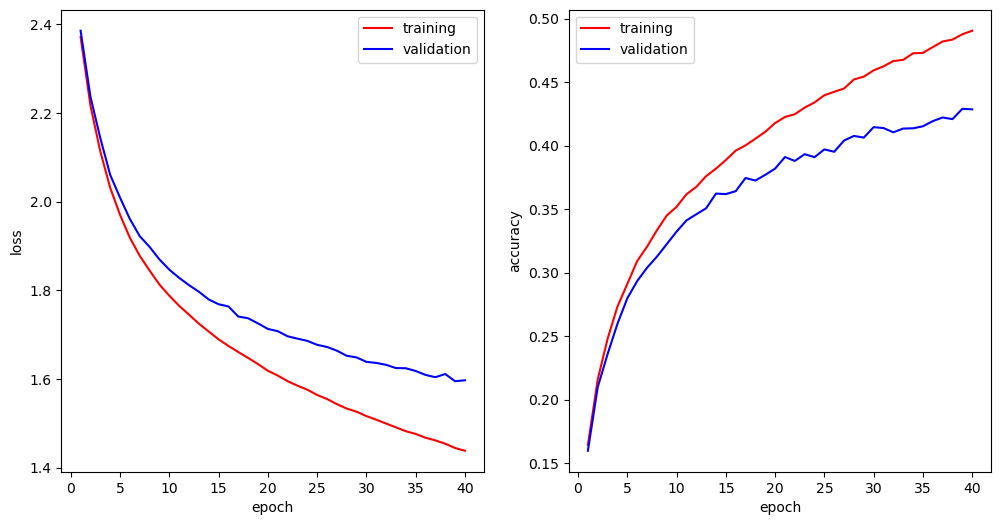

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 1.1981, Accuracy = 0.5699
client 2 : Loss = 0.6330, Accuracy = 0.7853
client 3 : Loss = 0.9364, Accuracy = 0.7446
client 4 : Loss = 1.0480, Accuracy = 0.5948
client 5 : Loss = 0.9802, Accuracy = 0.7034
client 6 : Loss = 0.7583, Accuracy = 0.8323
client 7 : Loss = 1.3448, Accuracy = 0.5712
client 8 : Loss = 0.9253, Accuracy = 0.6166

Server :
    - training loss = 2.3061
    - training accuracy = 0.1723
    - validation loss = 2.3292
    - validation accuracy = 0.1638
        
>>> Round 2 ...
client 1 : Loss = 1.1342, Accuracy = 0.5784
client 2 : Loss = 0.6194, Accuracy = 0.7925
client 3 : Loss = 0.8470, Accuracy = 0.7655
client 4 : Loss = 0.9682, Accuracy = 0.6178
client 5 : Loss = 0.8577, Accuracy = 0.7327
client 6 : Loss = 0.6617, Accuracy = 0.8490
cli

client 6 : Loss = 0.5271, Accuracy = 0.8644
client 7 : Loss = 0.8673, Accuracy = 0.7138
client 8 : Loss = 0.6545, Accuracy = 0.7311

Server :
    - training loss = 1.6548
    - training accuracy = 0.4099
    - validation loss = 1.7609
    - validation accuracy = 0.3698
        
>>> Round 17 ...
client 1 : Loss = 0.8370, Accuracy = 0.6874
client 2 : Loss = 0.4528, Accuracy = 0.8487
client 3 : Loss = 0.6265, Accuracy = 0.8126
client 4 : Loss = 0.6390, Accuracy = 0.7658
client 5 : Loss = 0.6617, Accuracy = 0.8052
client 6 : Loss = 0.5419, Accuracy = 0.8560
client 7 : Loss = 0.8794, Accuracy = 0.7108
client 8 : Loss = 0.6404, Accuracy = 0.7378

Server :
    - training loss = 1.6411
    - training accuracy = 0.4137
    - validation loss = 1.7552
    - validation accuracy = 0.3692
        
>>> Round 18 ...
client 1 : Loss = 0.8110, Accuracy = 0.6964
client 2 : Loss = 0.4668, Accuracy = 0.8453
client 3 : Loss = 0.6136, Accuracy = 0.8205
client 4 : Loss = 0.6282, Accuracy = 0.7736
client 5 : L

client 5 : Loss = 0.5461, Accuracy = 0.8493
client 6 : Loss = 0.5118, Accuracy = 0.8752
client 7 : Loss = 0.7452, Accuracy = 0.7554
client 8 : Loss = 0.5375, Accuracy = 0.7908

Server :
    - training loss = 1.4828
    - training accuracy = 0.4754
    - validation loss = 1.6485
    - validation accuracy = 0.4122
        
>>> Round 33 ...
client 1 : Loss = 0.6958, Accuracy = 0.7445
client 2 : Loss = 0.3877, Accuracy = 0.8773
client 3 : Loss = 0.5529, Accuracy = 0.8306
client 4 : Loss = 0.5213, Accuracy = 0.8151
client 5 : Loss = 0.5809, Accuracy = 0.8316
client 6 : Loss = 0.4890, Accuracy = 0.8732
client 7 : Loss = 0.7326, Accuracy = 0.7599
client 8 : Loss = 0.5318, Accuracy = 0.7928

Server :
    - training loss = 1.4763
    - training accuracy = 0.4786
    - validation loss = 1.6376
    - validation accuracy = 0.4174
        
>>> Round 34 ...
client 1 : Loss = 0.6982, Accuracy = 0.7436
client 2 : Loss = 0.4084, Accuracy = 0.8628
client 3 : Loss = 0.5383, Accuracy = 0.8435
client 4 : L

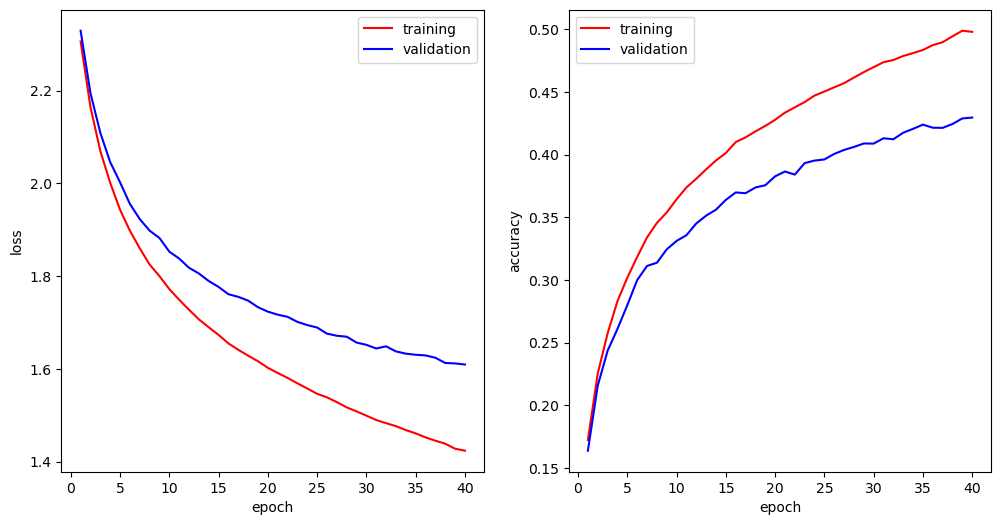

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 1.2345, Accuracy = 0.5511
client 2 : Loss = 0.6362, Accuracy = 0.7730
client 3 : Loss = 0.8849, Accuracy = 0.7537
client 4 : Loss = 1.0422, Accuracy = 0.5960
client 5 : Loss = 0.9686, Accuracy = 0.7212
client 6 : Loss = 0.7354, Accuracy = 0.8366
client 7 : Loss = 1.3824, Accuracy = 0.5613
client 8 : Loss = 0.9437, Accuracy = 0.6112

Server :
    - training loss = 2.3505
    - training accuracy = 0.1657
    - validation loss = 2.3741
    - validation accuracy = 0.1576
        
>>> Round 2 ...
client 1 : Loss = 1.1675, Accuracy = 0.5805
client 2 : Loss = 0.6075, Accuracy = 0.7889
client 3 : Loss = 0.8550, Accuracy = 0.7531
client 4 : Loss = 1.0028, Accuracy = 0.6089
client 5 : Loss = 0.9073, Accuracy = 0.7343
client 6 : Loss = 0.6917, Accuracy = 0.8362
cli

client 6 : Loss = 0.5276, Accuracy = 0.8643
client 7 : Loss = 0.8916, Accuracy = 0.6990
client 8 : Loss = 0.6570, Accuracy = 0.7265

Server :
    - training loss = 1.6601
    - training accuracy = 0.4012
    - validation loss = 1.7692
    - validation accuracy = 0.3614
        
>>> Round 17 ...
client 1 : Loss = 0.8473, Accuracy = 0.6825
client 2 : Loss = 0.4699, Accuracy = 0.8394
client 3 : Loss = 0.6247, Accuracy = 0.8203
client 4 : Loss = 0.6737, Accuracy = 0.7545
client 5 : Loss = 0.6040, Accuracy = 0.8227
client 6 : Loss = 0.5359, Accuracy = 0.8590
client 7 : Loss = 0.8666, Accuracy = 0.7146
client 8 : Loss = 0.6491, Accuracy = 0.7368

Server :
    - training loss = 1.6451
    - training accuracy = 0.4056
    - validation loss = 1.7514
    - validation accuracy = 0.3712
        
>>> Round 18 ...
client 1 : Loss = 0.8522, Accuracy = 0.6789
client 2 : Loss = 0.4726, Accuracy = 0.8373
client 3 : Loss = 0.6067, Accuracy = 0.8237
client 4 : Loss = 0.6646, Accuracy = 0.7486
client 5 : L

client 5 : Loss = 0.5089, Accuracy = 0.8572
client 6 : Loss = 0.5016, Accuracy = 0.8768
client 7 : Loss = 0.7635, Accuracy = 0.7432
client 8 : Loss = 0.5608, Accuracy = 0.7723

Server :
    - training loss = 1.4894
    - training accuracy = 0.4697
    - validation loss = 1.6385
    - validation accuracy = 0.4120
        
>>> Round 33 ...
client 1 : Loss = 0.7328, Accuracy = 0.7224
client 2 : Loss = 0.4162, Accuracy = 0.8580
client 3 : Loss = 0.5766, Accuracy = 0.8346
client 4 : Loss = 0.5351, Accuracy = 0.8101
client 5 : Loss = 0.5350, Accuracy = 0.8549
client 6 : Loss = 0.5041, Accuracy = 0.8633
client 7 : Loss = 0.7470, Accuracy = 0.7542
client 8 : Loss = 0.5587, Accuracy = 0.7737

Server :
    - training loss = 1.4816
    - training accuracy = 0.4732
    - validation loss = 1.6365
    - validation accuracy = 0.4168
        
>>> Round 34 ...
client 1 : Loss = 0.7062, Accuracy = 0.7388
client 2 : Loss = 0.4044, Accuracy = 0.8608
client 3 : Loss = 0.5849, Accuracy = 0.8353
client 4 : L

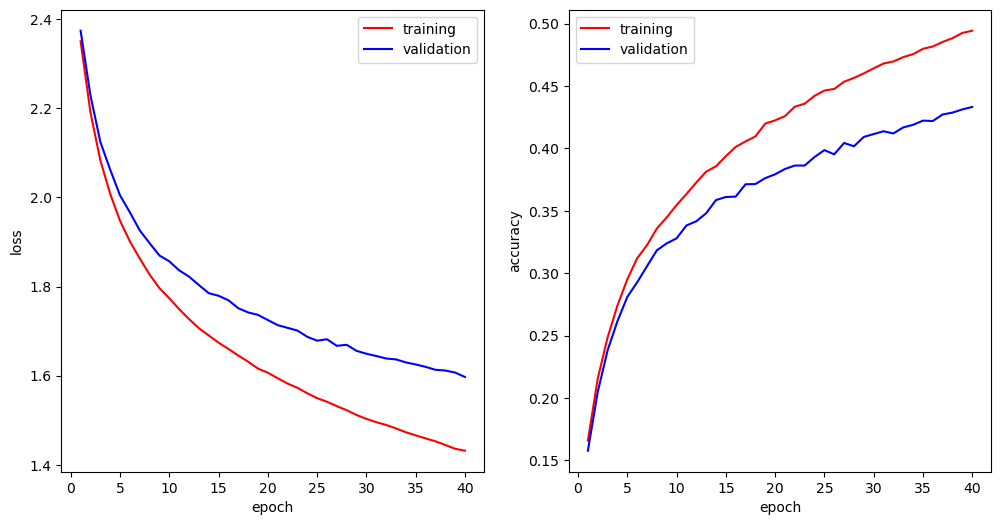

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 1.2032, Accuracy = 0.5658
client 2 : Loss = 0.6407, Accuracy = 0.7772
client 3 : Loss = 0.9111, Accuracy = 0.7508
client 4 : Loss = 1.0563, Accuracy = 0.5962
client 5 : Loss = 1.0112, Accuracy = 0.6773
client 6 : Loss = 0.7503, Accuracy = 0.8391
client 7 : Loss = 1.3495, Accuracy = 0.5611
client 8 : Loss = 0.9432, Accuracy = 0.6111

Server :
    - training loss = 2.3256
    - training accuracy = 0.1668
    - validation loss = 2.3449
    - validation accuracy = 0.1620
        
>>> Round 2 ...
client 1 : Loss = 1.1431, Accuracy = 0.5842
client 2 : Loss = 0.6235, Accuracy = 0.7823
client 3 : Loss = 0.8428, Accuracy = 0.7604
client 4 : Loss = 0.9968, Accuracy = 0.6105
client 5 : Loss = 0.9512, Accuracy = 0.7116
client 6 : Loss = 0.6804, Accuracy = 0.8411
cli

client 6 : Loss = 0.5077, Accuracy = 0.8742
client 7 : Loss = 0.8757, Accuracy = 0.7154
client 8 : Loss = 0.6627, Accuracy = 0.7261

Server :
    - training loss = 1.6657
    - training accuracy = 0.4019
    - validation loss = 1.7750
    - validation accuracy = 0.3603
        
>>> Round 17 ...
client 1 : Loss = 0.8422, Accuracy = 0.6878
client 2 : Loss = 0.4934, Accuracy = 0.8314
client 3 : Loss = 0.6126, Accuracy = 0.8260
client 4 : Loss = 0.6570, Accuracy = 0.7577
client 5 : Loss = 0.6408, Accuracy = 0.8165
client 6 : Loss = 0.5036, Accuracy = 0.8786
client 7 : Loss = 0.8471, Accuracy = 0.7152
client 8 : Loss = 0.6507, Accuracy = 0.7303

Server :
    - training loss = 1.6473
    - training accuracy = 0.4106
    - validation loss = 1.7577
    - validation accuracy = 0.3683
        
>>> Round 18 ...
client 1 : Loss = 0.8320, Accuracy = 0.6941
client 2 : Loss = 0.4803, Accuracy = 0.8403
client 3 : Loss = 0.5990, Accuracy = 0.8196
client 4 : Loss = 0.6512, Accuracy = 0.7576
client 5 : L

client 5 : Loss = 0.5696, Accuracy = 0.8418
client 6 : Loss = 0.4910, Accuracy = 0.8740
client 7 : Loss = 0.7465, Accuracy = 0.7501
client 8 : Loss = 0.5378, Accuracy = 0.7822

Server :
    - training loss = 1.4791
    - training accuracy = 0.4748
    - validation loss = 1.6449
    - validation accuracy = 0.4131
        
>>> Round 33 ...
client 1 : Loss = 0.6894, Accuracy = 0.7407
client 2 : Loss = 0.4285, Accuracy = 0.8647
client 3 : Loss = 0.5535, Accuracy = 0.8331
client 4 : Loss = 0.5197, Accuracy = 0.8206
client 5 : Loss = 0.5413, Accuracy = 0.8511
client 6 : Loss = 0.4796, Accuracy = 0.8804
client 7 : Loss = 0.7327, Accuracy = 0.7605
client 8 : Loss = 0.5400, Accuracy = 0.7832

Server :
    - training loss = 1.4711
    - training accuracy = 0.4788
    - validation loss = 1.6454
    - validation accuracy = 0.4097
        
>>> Round 34 ...
client 1 : Loss = 0.6983, Accuracy = 0.7383
client 2 : Loss = 0.4102, Accuracy = 0.8621
client 3 : Loss = 0.5419, Accuracy = 0.8366
client 4 : L

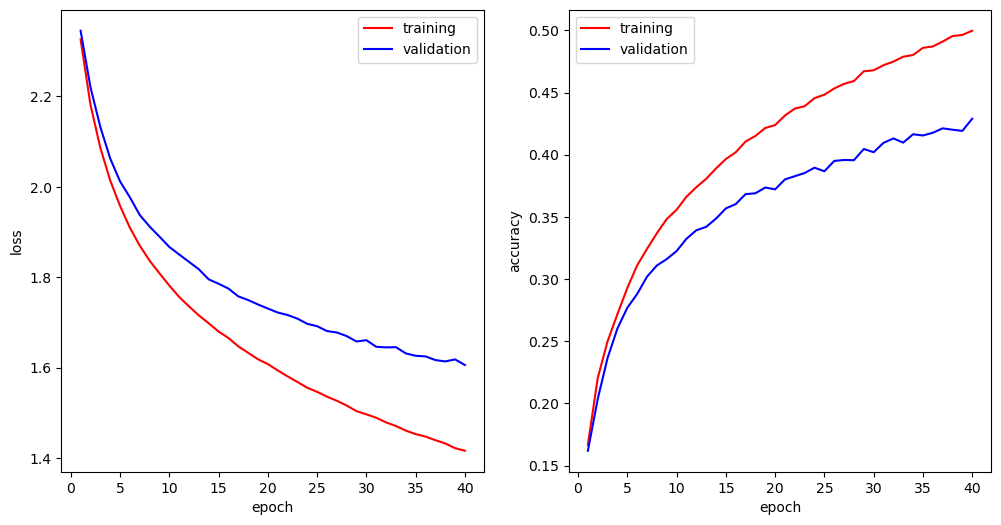

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 2.1359, Accuracy = 0.2979
client 2 : Loss = 1.6588, Accuracy = 0.4547
client 3 : Loss = 2.0962, Accuracy = 0.3648
client 4 : Loss = 2.2852, Accuracy = 0.3248
client 5 : Loss = 2.5827, Accuracy = 0.1695
client 6 : Loss = 2.3406, Accuracy = 0.2377
client 7 : Loss = 2.8973, Accuracy = 0.1579
client 8 : Loss = 2.0046, Accuracy = 0.3290

Server :
    - training loss = 2.7278
    - training accuracy = 0.1102
    - validation loss = 2.7151
    - validation accuracy = 0.1101
        
>>> Round 2 ...
client 1 : Loss = 2.0932, Accuracy = 0.3224
client 2 : Loss = 1.7296, Accuracy = 0.4276
client 3 : Loss = 2.0416, Accuracy = 0.3553
client 4 : Loss = 2.1147, Accuracy = 0.3321
client 5 : Loss = 2.4973, Accuracy = 0.1641
client 6 : Loss = 2.3152, Accuracy = 0.2345
cli

client 6 : Loss = 2.5268, Accuracy = 0.1972
client 7 : Loss = 2.1004, Accuracy = 0.3117
client 8 : Loss = 1.3904, Accuracy = 0.5232

Server :
    - training loss = 2.1249
    - training accuracy = 0.2480
    - validation loss = 2.1497
    - validation accuracy = 0.2392
        
>>> Round 17 ...
client 1 : Loss = 1.8818, Accuracy = 0.3763
client 2 : Loss = 1.9999, Accuracy = 0.3299
client 3 : Loss = 1.9793, Accuracy = 0.3638
client 4 : Loss = 1.5961, Accuracy = 0.4447
client 5 : Loss = 2.3536, Accuracy = 0.2193
client 6 : Loss = 2.5257, Accuracy = 0.1792
client 7 : Loss = 2.0938, Accuracy = 0.3147
client 8 : Loss = 1.3729, Accuracy = 0.5264

Server :
    - training loss = 2.1138
    - training accuracy = 0.2510
    - validation loss = 2.1323
    - validation accuracy = 0.2430
        
>>> Round 18 ...
client 1 : Loss = 1.9006, Accuracy = 0.3651
client 2 : Loss = 2.0197, Accuracy = 0.3176
client 3 : Loss = 1.9831, Accuracy = 0.3543
client 4 : Loss = 1.5959, Accuracy = 0.4339
client 5 : L

client 5 : Loss = 2.1730, Accuracy = 0.2428
client 6 : Loss = 2.4692, Accuracy = 0.1967
client 7 : Loss = 1.9349, Accuracy = 0.3607
client 8 : Loss = 1.2752, Accuracy = 0.5584

Server :
    - training loss = 1.9761
    - training accuracy = 0.2944
    - validation loss = 2.0091
    - validation accuracy = 0.2820
        
>>> Round 33 ...
client 1 : Loss = 1.7432, Accuracy = 0.4253
client 2 : Loss = 1.8997, Accuracy = 0.3626
client 3 : Loss = 1.8644, Accuracy = 0.4060
client 4 : Loss = 1.4414, Accuracy = 0.5057
client 5 : Loss = 2.1592, Accuracy = 0.2599
client 6 : Loss = 2.4888, Accuracy = 0.1828
client 7 : Loss = 1.9095, Accuracy = 0.3608
client 8 : Loss = 1.2525, Accuracy = 0.5684

Server :
    - training loss = 1.9704
    - training accuracy = 0.2965
    - validation loss = 2.0070
    - validation accuracy = 0.2847
        
>>> Round 34 ...
client 1 : Loss = 1.7715, Accuracy = 0.4135
client 2 : Loss = 1.9009, Accuracy = 0.3712
client 3 : Loss = 1.8693, Accuracy = 0.3845
client 4 : L

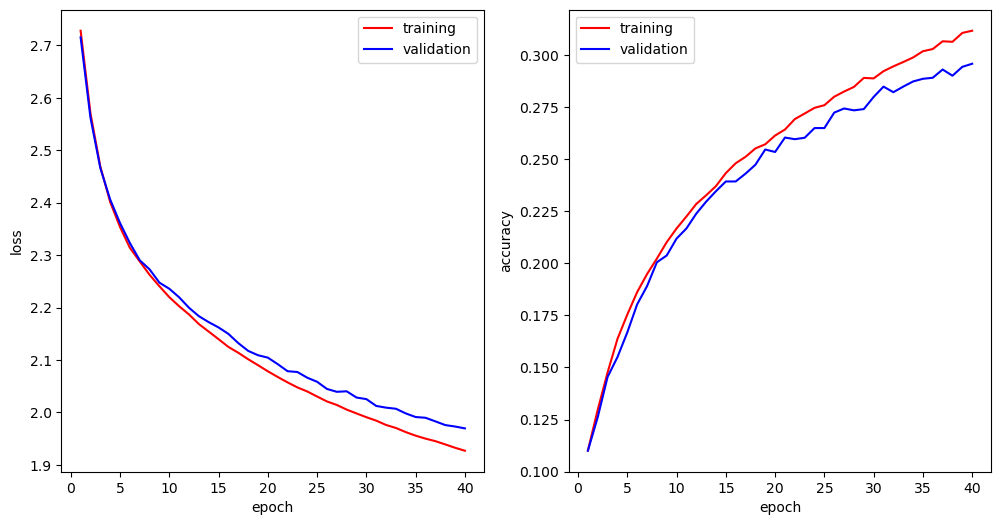

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 2.3181, Accuracy = 0.2422
client 2 : Loss = 2.1350, Accuracy = 0.2921
client 3 : Loss = 2.3286, Accuracy = 0.2069
client 4 : Loss = 1.7918, Accuracy = 0.3814
client 5 : Loss = 2.5849, Accuracy = 0.1808
client 6 : Loss = 2.8349, Accuracy = 0.1150
client 7 : Loss = 2.4684, Accuracy = 0.2430
client 8 : Loss = 1.8134, Accuracy = 0.3811

Server :
    - training loss = 2.5662
    - training accuracy = 0.1109
    - validation loss = 2.5628
    - validation accuracy = 0.1126
        
>>> Round 2 ...
client 1 : Loss = 2.2379, Accuracy = 0.2625
client 2 : Loss = 2.0966, Accuracy = 0.3025
client 3 : Loss = 2.2702, Accuracy = 0.2448
client 4 : Loss = 1.8062, Accuracy = 0.3749
client 5 : Loss = 2.5695, Accuracy = 0.1778
client 6 : Loss = 2.7572, Accuracy = 0.1390
cli

client 6 : Loss = 2.4582, Accuracy = 0.1771
client 7 : Loss = 2.0893, Accuracy = 0.3118
client 8 : Loss = 1.3615, Accuracy = 0.5322

Server :
    - training loss = 2.1212
    - training accuracy = 0.2433
    - validation loss = 2.1387
    - validation accuracy = 0.2369
        
>>> Round 17 ...
client 1 : Loss = 1.8817, Accuracy = 0.3825
client 2 : Loss = 1.9217, Accuracy = 0.3489
client 3 : Loss = 2.0018, Accuracy = 0.3519
client 4 : Loss = 1.5911, Accuracy = 0.4566
client 5 : Loss = 2.3274, Accuracy = 0.2296
client 6 : Loss = 2.4857, Accuracy = 0.1733
client 7 : Loss = 2.0718, Accuracy = 0.3231
client 8 : Loss = 1.3585, Accuracy = 0.5309

Server :
    - training loss = 2.1063
    - training accuracy = 0.2466
    - validation loss = 2.1266
    - validation accuracy = 0.2374
        
>>> Round 18 ...
client 1 : Loss = 1.8679, Accuracy = 0.3875
client 2 : Loss = 1.8966, Accuracy = 0.3594
client 3 : Loss = 2.0303, Accuracy = 0.3352
client 4 : Loss = 1.5830, Accuracy = 0.4533
client 5 : L

client 5 : Loss = 2.2004, Accuracy = 0.2701
client 6 : Loss = 2.3706, Accuracy = 0.2010
client 7 : Loss = 1.9455, Accuracy = 0.3602
client 8 : Loss = 1.2428, Accuracy = 0.5667

Server :
    - training loss = 1.9680
    - training accuracy = 0.2928
    - validation loss = 2.0019
    - validation accuracy = 0.2831
        
>>> Round 33 ...
client 1 : Loss = 1.7432, Accuracy = 0.4218
client 2 : Loss = 1.8127, Accuracy = 0.3777
client 3 : Loss = 1.8948, Accuracy = 0.3968
client 4 : Loss = 1.4545, Accuracy = 0.5058
client 5 : Loss = 2.1690, Accuracy = 0.2500
client 6 : Loss = 2.3986, Accuracy = 0.1960
client 7 : Loss = 1.9557, Accuracy = 0.3618
client 8 : Loss = 1.2425, Accuracy = 0.5726

Server :
    - training loss = 1.9613
    - training accuracy = 0.2944
    - validation loss = 1.9962
    - validation accuracy = 0.2824
        
>>> Round 34 ...
client 1 : Loss = 1.7536, Accuracy = 0.4320
client 2 : Loss = 1.7872, Accuracy = 0.3938
client 3 : Loss = 1.9073, Accuracy = 0.3649
client 4 : L

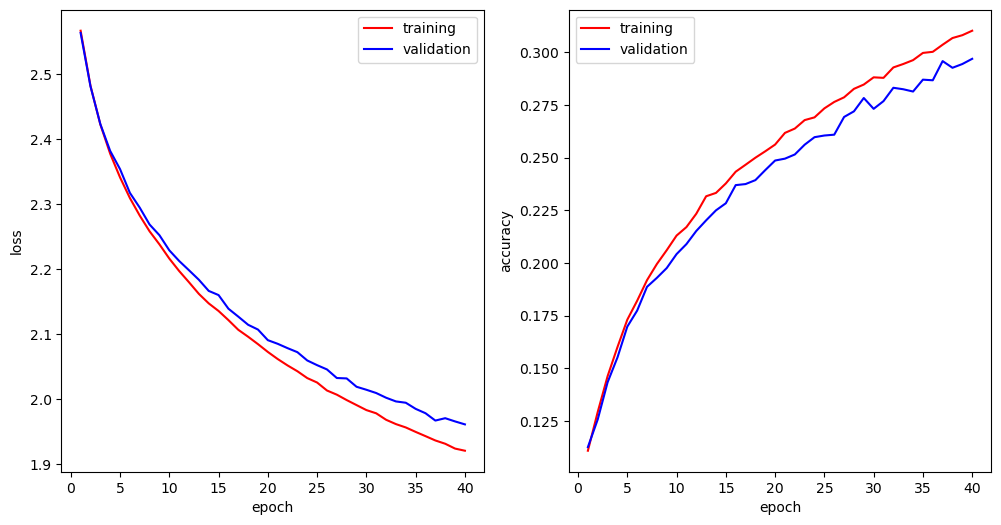

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 2.2344, Accuracy = 0.2941
client 2 : Loss = 1.7065, Accuracy = 0.4641
client 3 : Loss = 2.3410, Accuracy = 0.2475
client 4 : Loss = 2.1178, Accuracy = 0.3115
client 5 : Loss = 2.2320, Accuracy = 0.2472
client 6 : Loss = 2.7614, Accuracy = 0.1302
client 7 : Loss = 2.4322, Accuracy = 0.2336
client 8 : Loss = 1.7784, Accuracy = 0.3777

Server :
    - training loss = 2.5726
    - training accuracy = 0.1138
    - validation loss = 2.5704
    - validation accuracy = 0.1140
        
>>> Round 2 ...
client 1 : Loss = 2.1695, Accuracy = 0.3016
client 2 : Loss = 1.7838, Accuracy = 0.4381
client 3 : Loss = 2.2246, Accuracy = 0.2833
client 4 : Loss = 2.0208, Accuracy = 0.3293
client 5 : Loss = 2.3414, Accuracy = 0.2144
client 6 : Loss = 2.6709, Accuracy = 0.1366
cli

client 6 : Loss = 2.4684, Accuracy = 0.1757
client 7 : Loss = 2.0613, Accuracy = 0.3212
client 8 : Loss = 1.3366, Accuracy = 0.5327

Server :
    - training loss = 2.1247
    - training accuracy = 0.2432
    - validation loss = 2.1512
    - validation accuracy = 0.2332
        
>>> Round 17 ...
client 1 : Loss = 1.9353, Accuracy = 0.3635
client 2 : Loss = 1.9619, Accuracy = 0.3377
client 3 : Loss = 1.9790, Accuracy = 0.3786
client 4 : Loss = 1.6184, Accuracy = 0.4386
client 5 : Loss = 2.3914, Accuracy = 0.2091
client 6 : Loss = 2.4977, Accuracy = 0.1711
client 7 : Loss = 2.0339, Accuracy = 0.3362
client 8 : Loss = 1.3467, Accuracy = 0.5365

Server :
    - training loss = 2.1123
    - training accuracy = 0.2463
    - validation loss = 2.1358
    - validation accuracy = 0.2386
        
>>> Round 18 ...
client 1 : Loss = 1.9399, Accuracy = 0.3706
client 2 : Loss = 1.9514, Accuracy = 0.3462
client 3 : Loss = 1.9778, Accuracy = 0.3695
client 4 : Loss = 1.6305, Accuracy = 0.4352
client 5 : L

client 5 : Loss = 2.1580, Accuracy = 0.2687
client 6 : Loss = 2.3982, Accuracy = 0.2079
client 7 : Loss = 1.9272, Accuracy = 0.3609
client 8 : Loss = 1.2343, Accuracy = 0.5748

Server :
    - training loss = 1.9742
    - training accuracy = 0.2910
    - validation loss = 2.0228
    - validation accuracy = 0.2751
        
>>> Round 33 ...
client 1 : Loss = 1.7953, Accuracy = 0.4044
client 2 : Loss = 1.8143, Accuracy = 0.3895
client 3 : Loss = 1.9235, Accuracy = 0.3736
client 4 : Loss = 1.4814, Accuracy = 0.4926
client 5 : Loss = 2.1478, Accuracy = 0.2553
client 6 : Loss = 2.4113, Accuracy = 0.1989
client 7 : Loss = 1.8941, Accuracy = 0.3752
client 8 : Loss = 1.2284, Accuracy = 0.5751

Server :
    - training loss = 1.9658
    - training accuracy = 0.2950
    - validation loss = 2.0165
    - validation accuracy = 0.2756
        
>>> Round 34 ...
client 1 : Loss = 1.8055, Accuracy = 0.4005
client 2 : Loss = 1.7990, Accuracy = 0.3897
client 3 : Loss = 1.9108, Accuracy = 0.3638
client 4 : L

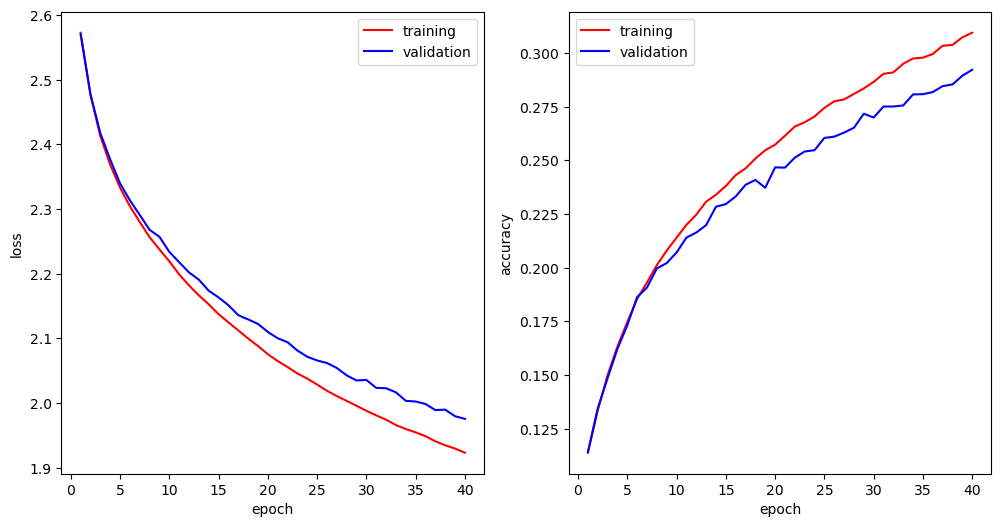

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 2.0052, Accuracy = 0.3206
client 2 : Loss = 1.8258, Accuracy = 0.3833
client 3 : Loss = 2.2390, Accuracy = 0.2653
client 4 : Loss = 2.0229, Accuracy = 0.3150
client 5 : Loss = 2.4302, Accuracy = 0.1751
client 6 : Loss = 1.9879, Accuracy = 0.3635
client 7 : Loss = 2.4094, Accuracy = 0.2151
client 8 : Loss = 1.9292, Accuracy = 0.3444

Server :
    - training loss = 2.5243
    - training accuracy = 0.1168
    - validation loss = 2.5446
    - validation accuracy = 0.1162
        
>>> Round 2 ...
client 1 : Loss = 2.0299, Accuracy = 0.3181
client 2 : Loss = 1.9039, Accuracy = 0.3616
client 3 : Loss = 2.1076, Accuracy = 0.3105
client 4 : Loss = 1.9347, Accuracy = 0.3331
client 5 : Loss = 2.4340, Accuracy = 0.1873
client 6 : Loss = 2.0706, Accuracy = 0.3148
cli

client 6 : Loss = 2.4469, Accuracy = 0.1867
client 7 : Loss = 2.0651, Accuracy = 0.3174
client 8 : Loss = 1.3892, Accuracy = 0.5239

Server :
    - training loss = 2.1042
    - training accuracy = 0.2494
    - validation loss = 2.1491
    - validation accuracy = 0.2380
        
>>> Round 17 ...
client 1 : Loss = 1.9321, Accuracy = 0.3533
client 2 : Loss = 1.9706, Accuracy = 0.3461
client 3 : Loss = 1.9346, Accuracy = 0.3818
client 4 : Loss = 1.6006, Accuracy = 0.4417
client 5 : Loss = 2.1826, Accuracy = 0.2703
client 6 : Loss = 2.4516, Accuracy = 0.1713
client 7 : Loss = 2.0512, Accuracy = 0.3267
client 8 : Loss = 1.3769, Accuracy = 0.5240

Server :
    - training loss = 2.0915
    - training accuracy = 0.2527
    - validation loss = 2.1358
    - validation accuracy = 0.2419
        
>>> Round 18 ...
client 1 : Loss = 1.9102, Accuracy = 0.3688
client 2 : Loss = 1.9518, Accuracy = 0.3427
client 3 : Loss = 1.9180, Accuracy = 0.3709
client 4 : Loss = 1.5854, Accuracy = 0.4449
client 5 : L

client 5 : Loss = 2.1333, Accuracy = 0.2778
client 6 : Loss = 2.3984, Accuracy = 0.2036
client 7 : Loss = 1.9168, Accuracy = 0.3635
client 8 : Loss = 1.2799, Accuracy = 0.5520

Server :
    - training loss = 1.9564
    - training accuracy = 0.3000
    - validation loss = 2.0176
    - validation accuracy = 0.2778
        
>>> Round 33 ...
client 1 : Loss = 1.8044, Accuracy = 0.3974
client 2 : Loss = 1.8607, Accuracy = 0.3790
client 3 : Loss = 1.9156, Accuracy = 0.3825
client 4 : Loss = 1.4731, Accuracy = 0.4874
client 5 : Loss = 2.1051, Accuracy = 0.2869
client 6 : Loss = 2.3889, Accuracy = 0.1964
client 7 : Loss = 1.8958, Accuracy = 0.3779
client 8 : Loss = 1.2653, Accuracy = 0.5654

Server :
    - training loss = 1.9477
    - training accuracy = 0.3018
    - validation loss = 2.0119
    - validation accuracy = 0.2745
        
>>> Round 34 ...
client 1 : Loss = 1.8093, Accuracy = 0.3957
client 2 : Loss = 1.8731, Accuracy = 0.3757
client 3 : Loss = 1.8488, Accuracy = 0.3825
client 4 : L

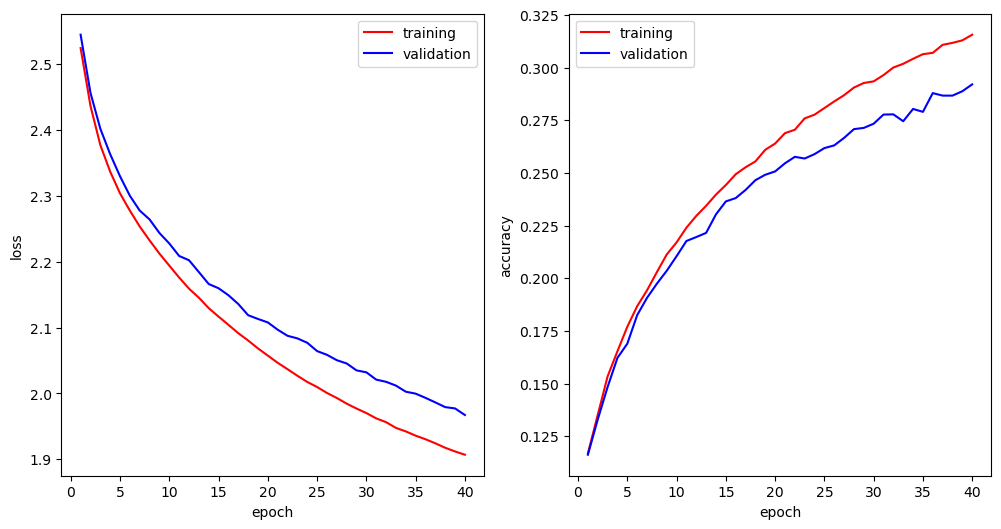

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 2.1205, Accuracy = 0.3239
client 2 : Loss = 2.2253, Accuracy = 0.2548
client 3 : Loss = 2.4209, Accuracy = 0.2225
client 4 : Loss = 1.9272, Accuracy = 0.3373
client 5 : Loss = 2.4537, Accuracy = 0.2037
client 6 : Loss = 2.5160, Accuracy = 0.1976
client 7 : Loss = 2.4114, Accuracy = 0.2288
client 8 : Loss = 1.7734, Accuracy = 0.3984

Server :
    - training loss = 2.5194
    - training accuracy = 0.1236
    - validation loss = 2.5148
    - validation accuracy = 0.1300
        
>>> Round 2 ...
client 1 : Loss = 2.1272, Accuracy = 0.3164
client 2 : Loss = 2.1905, Accuracy = 0.2674
client 3 : Loss = 2.3071, Accuracy = 0.2554
client 4 : Loss = 1.8646, Accuracy = 0.3545
client 5 : Loss = 2.5379, Accuracy = 0.1828
client 6 : Loss = 2.4954, Accuracy = 0.1981
cli

client 6 : Loss = 2.5140, Accuracy = 0.1770
client 7 : Loss = 2.0573, Accuracy = 0.3127
client 8 : Loss = 1.3466, Accuracy = 0.5310

Server :
    - training loss = 2.1440
    - training accuracy = 0.2370
    - validation loss = 2.1730
    - validation accuracy = 0.2296
        
>>> Round 17 ...
client 1 : Loss = 1.9275, Accuracy = 0.3614
client 2 : Loss = 2.0428, Accuracy = 0.3056
client 3 : Loss = 2.0139, Accuracy = 0.3518
client 4 : Loss = 1.5727, Accuracy = 0.4584
client 5 : Loss = 2.3604, Accuracy = 0.2160
client 6 : Loss = 2.4756, Accuracy = 0.1791
client 7 : Loss = 2.0567, Accuracy = 0.3195
client 8 : Loss = 1.3291, Accuracy = 0.5406

Server :
    - training loss = 2.1303
    - training accuracy = 0.2420
    - validation loss = 2.1586
    - validation accuracy = 0.2320
        
>>> Round 18 ...
client 1 : Loss = 1.9261, Accuracy = 0.3648
client 2 : Loss = 2.0391, Accuracy = 0.3256
client 3 : Loss = 1.9676, Accuracy = 0.3423
client 4 : Loss = 1.5805, Accuracy = 0.4461
client 5 : L

client 5 : Loss = 2.1808, Accuracy = 0.2665
client 6 : Loss = 2.3973, Accuracy = 0.1829
client 7 : Loss = 1.9083, Accuracy = 0.3606
client 8 : Loss = 1.2570, Accuracy = 0.5581

Server :
    - training loss = 1.9887
    - training accuracy = 0.2848
    - validation loss = 2.0350
    - validation accuracy = 0.2690
        
>>> Round 33 ...
client 1 : Loss = 1.8063, Accuracy = 0.4027
client 2 : Loss = 1.8904, Accuracy = 0.3559
client 3 : Loss = 1.8822, Accuracy = 0.3861
client 4 : Loss = 1.4461, Accuracy = 0.5047
client 5 : Loss = 2.2045, Accuracy = 0.2625
client 6 : Loss = 2.4173, Accuracy = 0.1923
client 7 : Loss = 1.9145, Accuracy = 0.3663
client 8 : Loss = 1.2500, Accuracy = 0.5661

Server :
    - training loss = 1.9835
    - training accuracy = 0.2885
    - validation loss = 2.0316
    - validation accuracy = 0.2684
        
>>> Round 34 ...
client 1 : Loss = 1.7980, Accuracy = 0.4020
client 2 : Loss = 1.8911, Accuracy = 0.3609
client 3 : Loss = 1.8663, Accuracy = 0.3787
client 4 : L

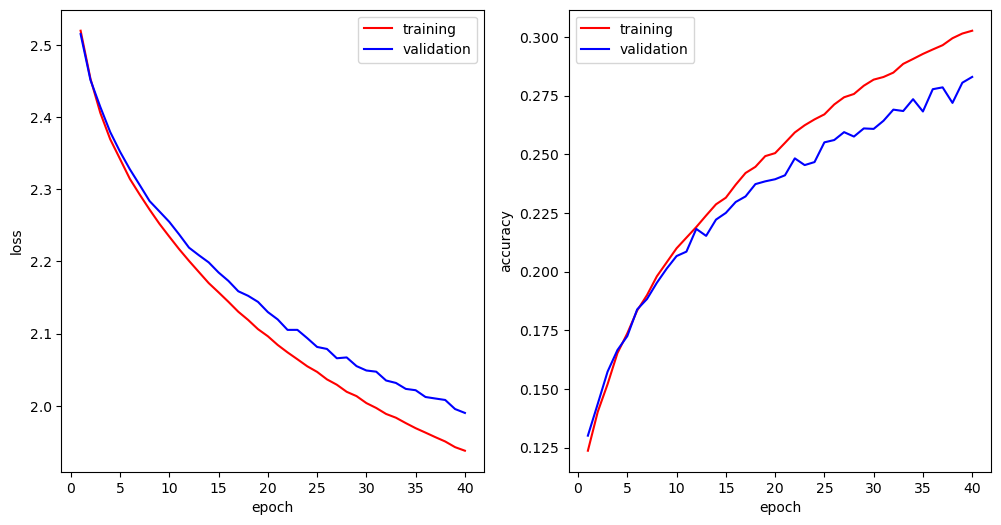

RESULTS
lr = 0.1000 : Accuracy = 0.5730419158935547
lr = 0.0100 : Accuracy = 0.5009493827819824
lr = 0.0010 : Accuracy = 0.43077531456947327
lr = 0.0001 : Accuracy = 0.29195016622543335

CPU times: user 4h 29min 46s, sys: 14.2 s, total: 4h 30min
Wall time: 4h 30min 16s


In [10]:
%%time
n_splits = 5
rounds = 40
batch_size = 128
epochs = 5
lrs = [1e-1,1e-2,1e-3,1e-4]
optimizer = optim.SGD

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()
